Il doit comprendre une introduction, une description
succincte des algorithmes utilisés, une interprétation des résultats, une conclusion, etc.

In [105]:
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(caret)

# INTRODUCTION

Analyse exploratoire des données
L’objectif dans un premier temps est d’explorer les différentes variables, étape préliminaire indispensable à
l’analyse. Ci-dessous sont précisées quelques questions basiques. Vous pouvez compléter l’analyse selon vos
propres idées.
1. Commencez par une analyse descriptive unidimensionnelle des données. Voyez-vous des anomalies?
2. Des transformations des variables quantitatives vous semblent-t-elles pertinentes ? Certaines variables
qualitatives ont de nombreuses modalités, il peut être pertinent de regrouper certaines modalités entre
elles.
3. Les distributions sont-elles comparables entre le jeu d’apprentissage et le jeu de test ?
4. Poursuivez avec une analyse descriptive multidimensionnelle. Utilisez des techniques de visualisation :
par exemple scatterplot, correlation plot ... Analysez les dépendances entre les variables.
5. Réalisez une analyse en composantes principales des variables quantitatives et interprétez les résultats.
6. Visualisez la possible dépendance entre les variables qualitatives et la variable à prédire.

In [3]:
# Lecture des données
data <- read.table("biodeg.csv", header = FALSE, sep=';')

name_keep_index = 1+c(0, 1, 7, 11, 12, 13, 14, 15, 16, 17, 21, 23, 24, 26, 27, 29,30, 35, 36, 38)

biodeg = as.data.frame(data[, 42])
colnames(biodeg) = c('Response')

biodeg[, "Response"] <- as.factor(biodeg[, "Response"]) #2: RB, 1: NRB

data <- data[, name_keep_index]
colnames(data) <- list('SpMax_L', 'J_Dz(e)', 'C%', 'SdssC', 'HyWi_B(m)', 'LOC', 'SM6_L',
       'F03[C-O]', 'Me', 'Mi', 'SpPosA_B(p)', 'B01[C-Br]', 'B03[C-Cl]',
       'SpMax_A', 'Psi_i_1d', 'SdO', 'TI2_L', 'SpMax_B(m)', 'Psi_i_A',
       'SM6_B(m)')

# Premières lignes du jeu de données
head(data)

head(biodeg)


,SpMax_L,J_Dz(e),C%,SdssC,HyWi_B(m),LOC,SM6_L,F03[C-O],Me,Mi,SpPosA_B(p),B01[C-Br],B03[C-Cl],SpMax_A,Psi_i_1d,SdO,TI2_L,SpMax_B(m),Psi_i_A,SM6_B(m)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.919,2.6909,31.4,0.000,3.106,2.550,9.002,0,0.960,1.142,1.201,0,0,1.932,0.011,0.000,4.489,2.949,1.591,7.253
2,4.170,2.1144,30.8,0.000,2.461,1.393,8.723,1,0.989,1.144,1.104,0,0,2.214,-0.204,0.000,1.542,3.315,1.967,7.257
3,3.932,3.2512,26.7,0.000,3.279,2.585,9.110,0,1.009,1.152,1.092,0,0,1.942,-0.008,0.000,4.891,3.076,2.417,7.601
4,3.000,2.7098,20.0,0.000,2.100,0.918,6.594,0,1.108,1.167,1.024,0,0,1.414,1.073,8.361,1.333,3.046,5.000,6.690
5,4.236,3.3944,29.4,-0.271,3.449,2.753,9.528,2,1.004,1.147,1.137,0,0,1.985,-0.002,10.348,5.588,3.351,2.405,8.003
6,4.236,3.4286,28.6,-0.275,3.313,2.522,9.383,1,1.014,1.149,1.119,0,0,1.980,-0.008,10.276,4.746,3.351,2.556,7.904


,Response
,<fct>
1,RB
2,RB
3,RB
4,RB
5,RB
6,RB


## Misssing data

In [4]:
print(paste("Number of missing values in dataset : ", sum(sapply(data, function(x) sum(is.na(x)))))) #0
print(paste("Number of missing values in dataset of response variable : ", sum(sapply(biodeg, function(x) sum(is.na(x)))))) #0                             

[1] "Number of missing values in dataset :  0"
[1] "Number of missing values in dataset of response variable :  0"


**Comment**: There is no missing values.

# Explanatory Data Analysis

## Unidimensional

In [5]:
quali_index <- 1+c(7, 11, 12)
quanti_index <- setdiff(1:20, quali_index)

quali_list <- colnames(data)[quali_index]
quanti_list <- colnames(data)[quanti_index]

### Response variables

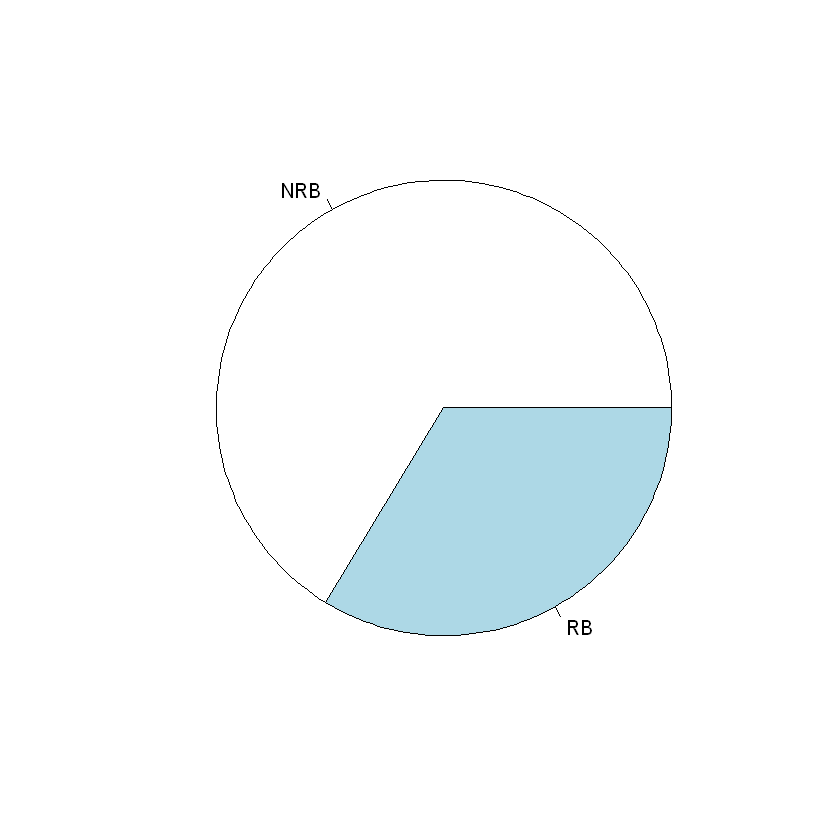

In [6]:
pie(table(biodeg[, 1]))

### Quantitative variables

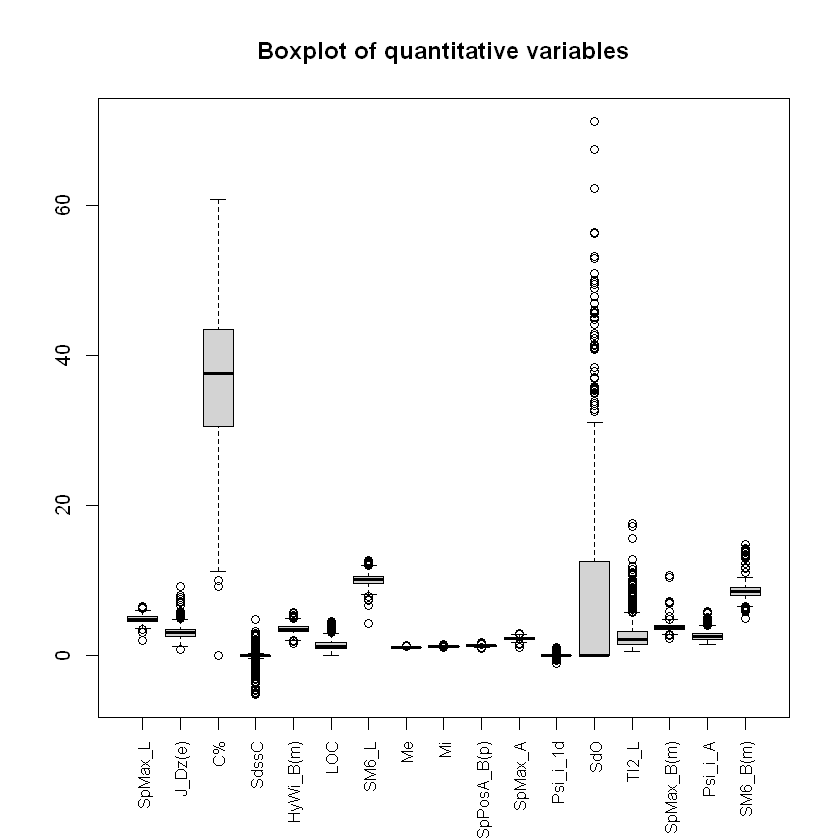

In [7]:
boxplot_data <- data[,quanti_index]

boxplot(boxplot_data, main = 'Boxplot of quantitative variables',
        names = quanti_list, xaxt = 'n')
axis(1, at = 1:length(quanti_list), labels = quanti_list, las = 2, cex.axis = 0.8)


**Comment**: There exists outliers and scale difference between the quantitative variables.

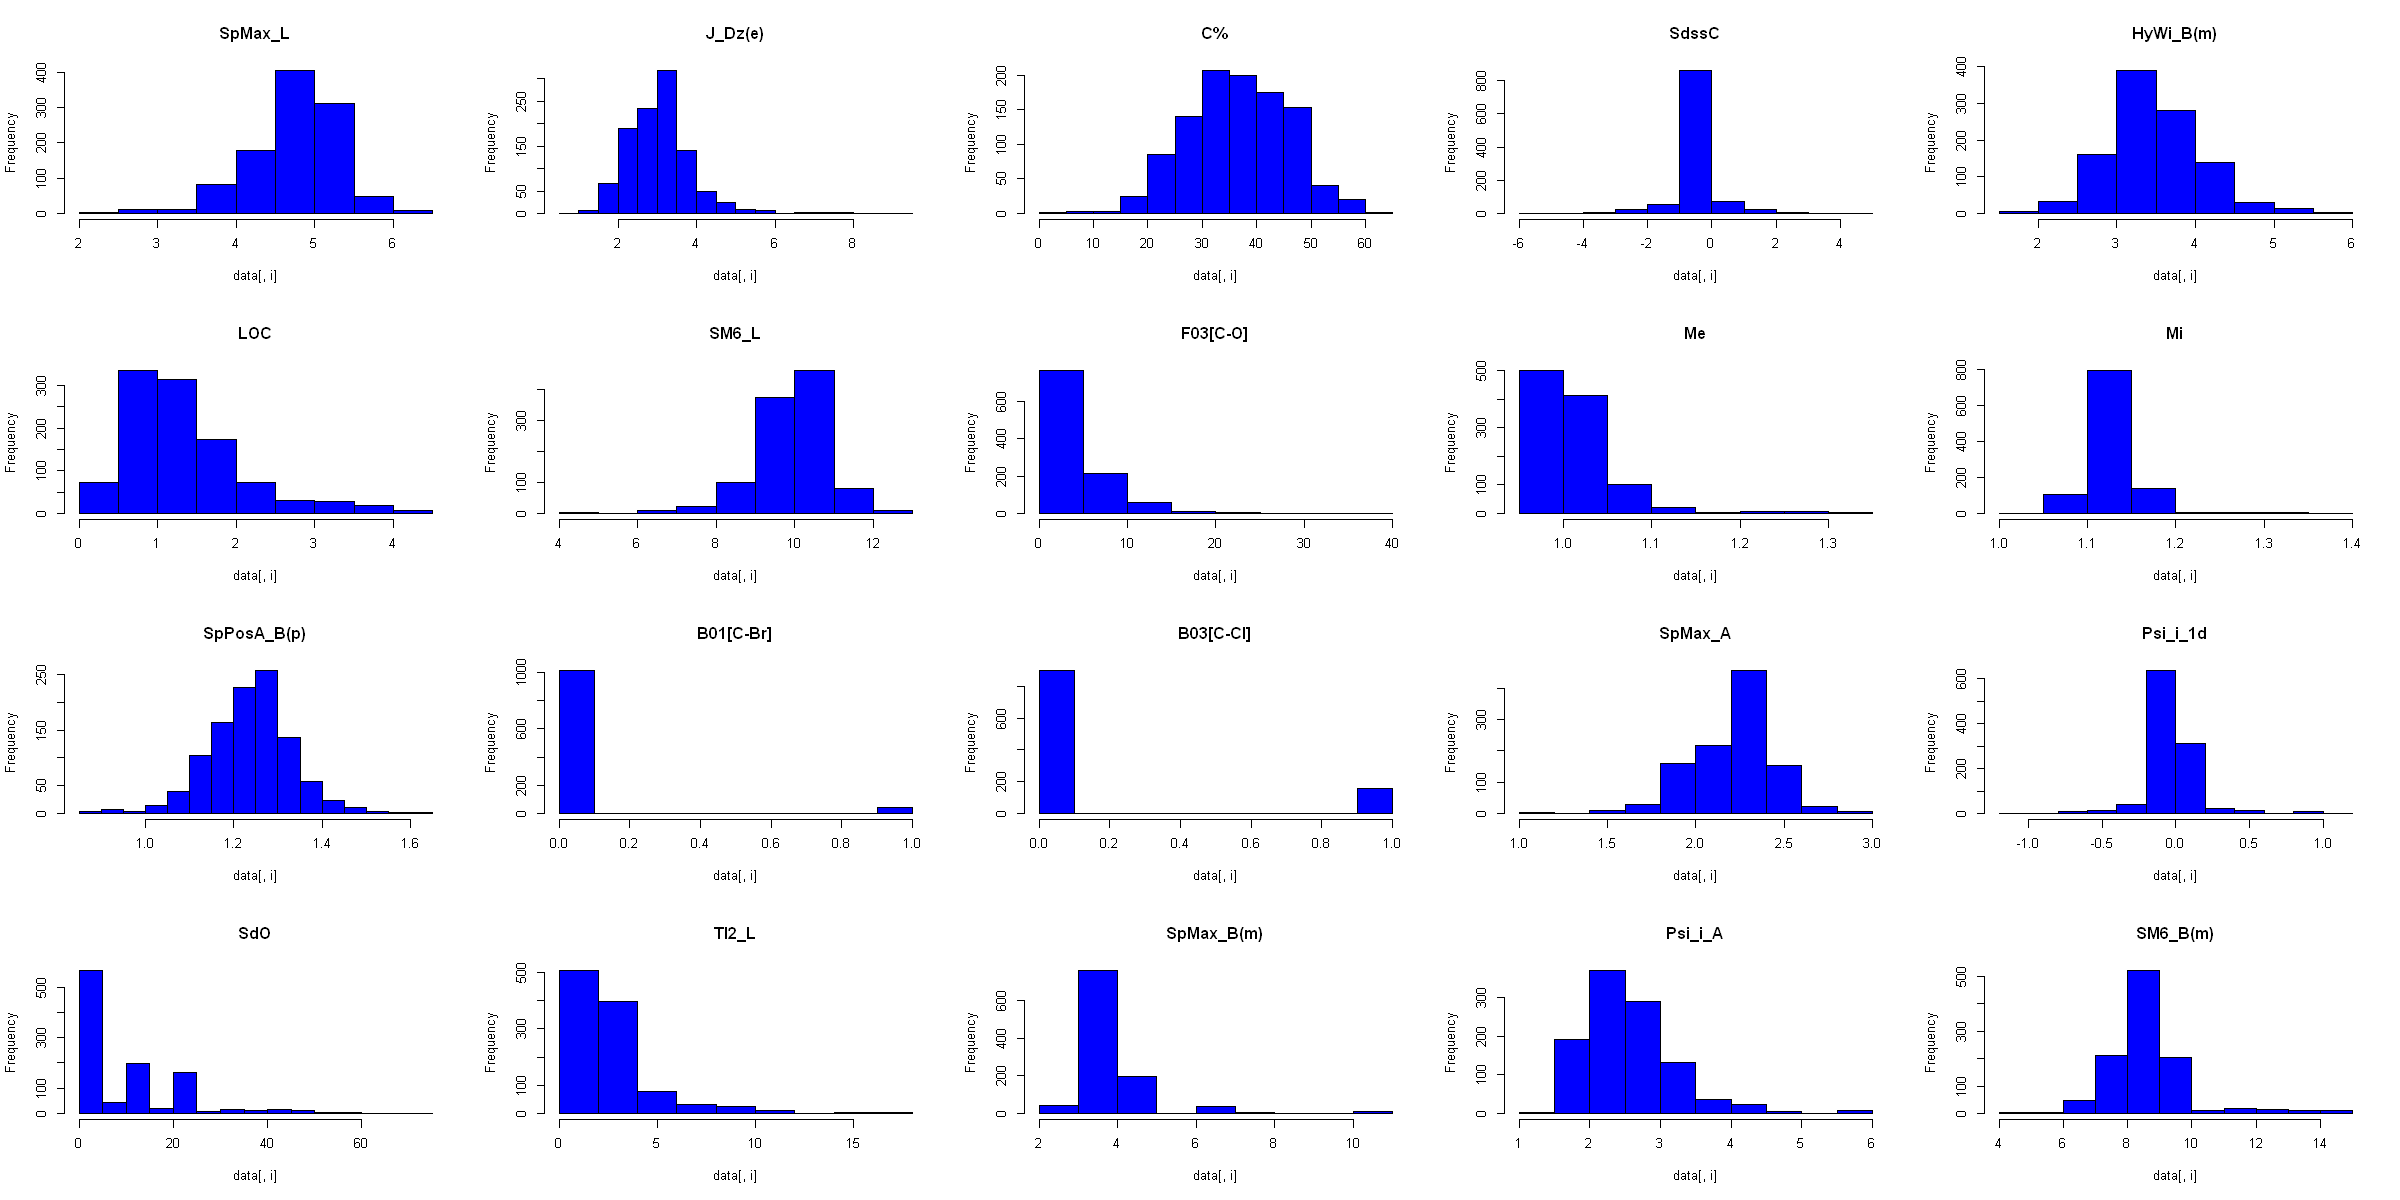

In [8]:
data_quali = data[, quali_index]

par(mfrow = c(4, 5))
options(repr.plot.width = 20, repr.plot.height = 10)
for (i in 1:20) {
    hist(data[, i], col = "blue", main = colnames(data)[i])
}

In [9]:
library(dplyr)
library(magrittr)

data_transform <- data

# left skewed
data_transform$SM6_L <- log((max(data$SM6_L) + 1) - data$SM6_L)
data_transform$SpMax_A <- log((max(data$SpMax_A) + 1) - data$SpMax_A)
data_transform$SpMax_L <- log((max(data$SpMax_L) + 1) - data$SpMax_L)

# right skewed
data_transform$TI2_L <- log(data$TI2_L)
data_transform$'J_Dz(e)' <- log(data$'J_Dz(e)')
data_transform$Psi_i_A <- log(data$Psi_i_A)
data_transform$'SM6_B(m)' <- log(data$'SM6_B(m)')
data_transform$LOC <- log10(data$LOC + 1)
data_transform$'SpMax_B(m)' <- log(data$'SpMax_B(m)')

data_transform$'HyWi_B(m)' <- sqrt(data$'HyWi_B(m)')



Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract




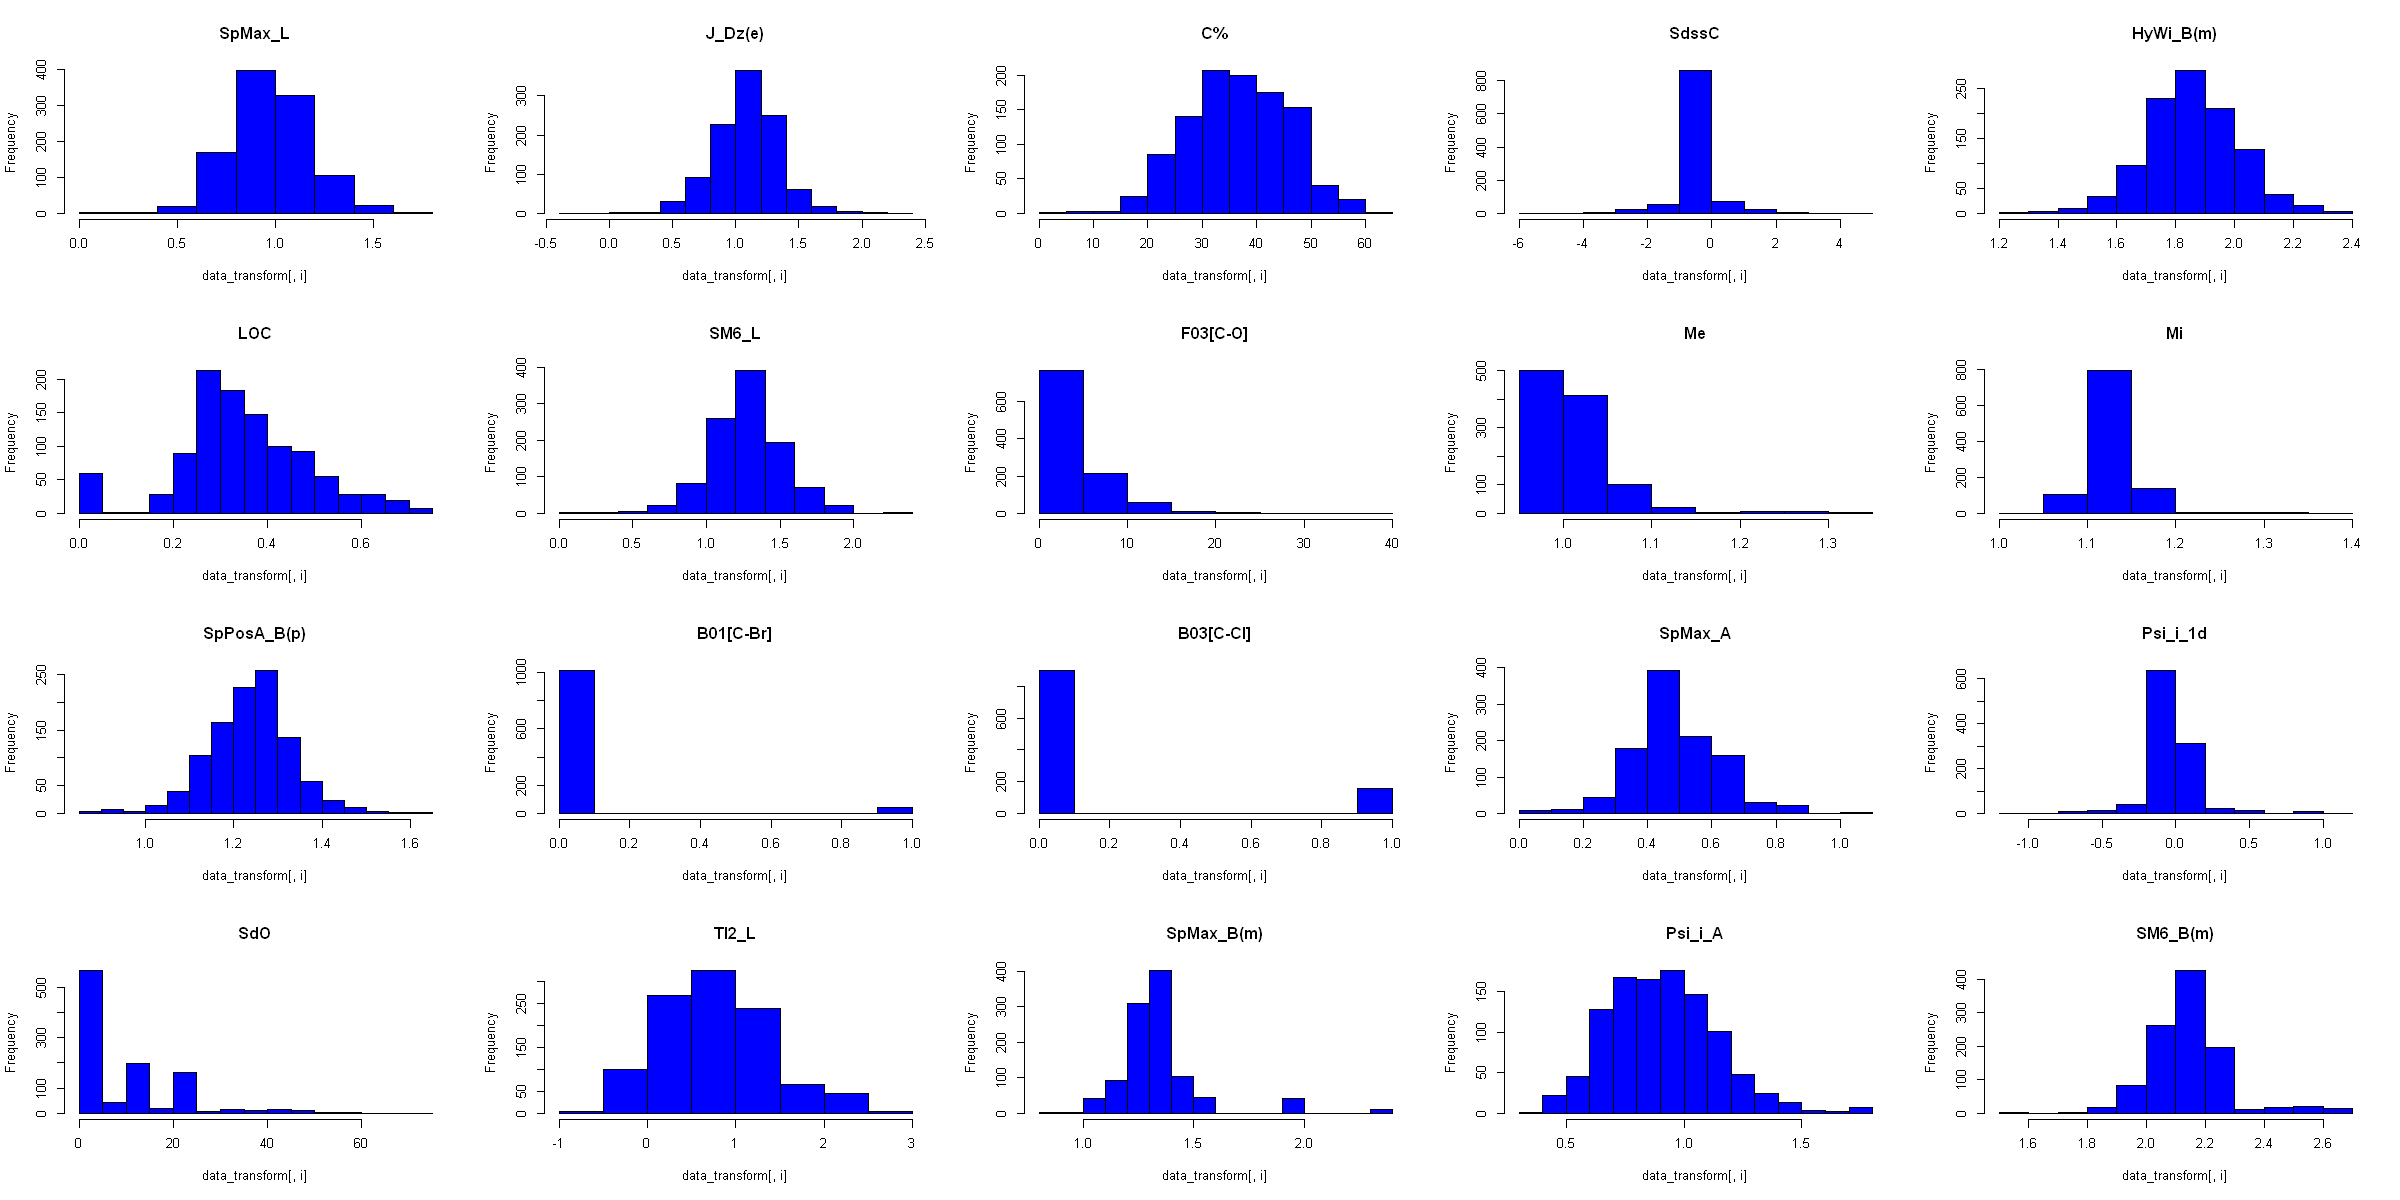

In [10]:
par(mfrow = c(4, 5))
options(repr.plot.width = 20, repr.plot.height = 10)
for (i in 1:20) {
    hist(data_transform[, i], col = "blue", main = colnames(data)[i])
}

### Categorical variables

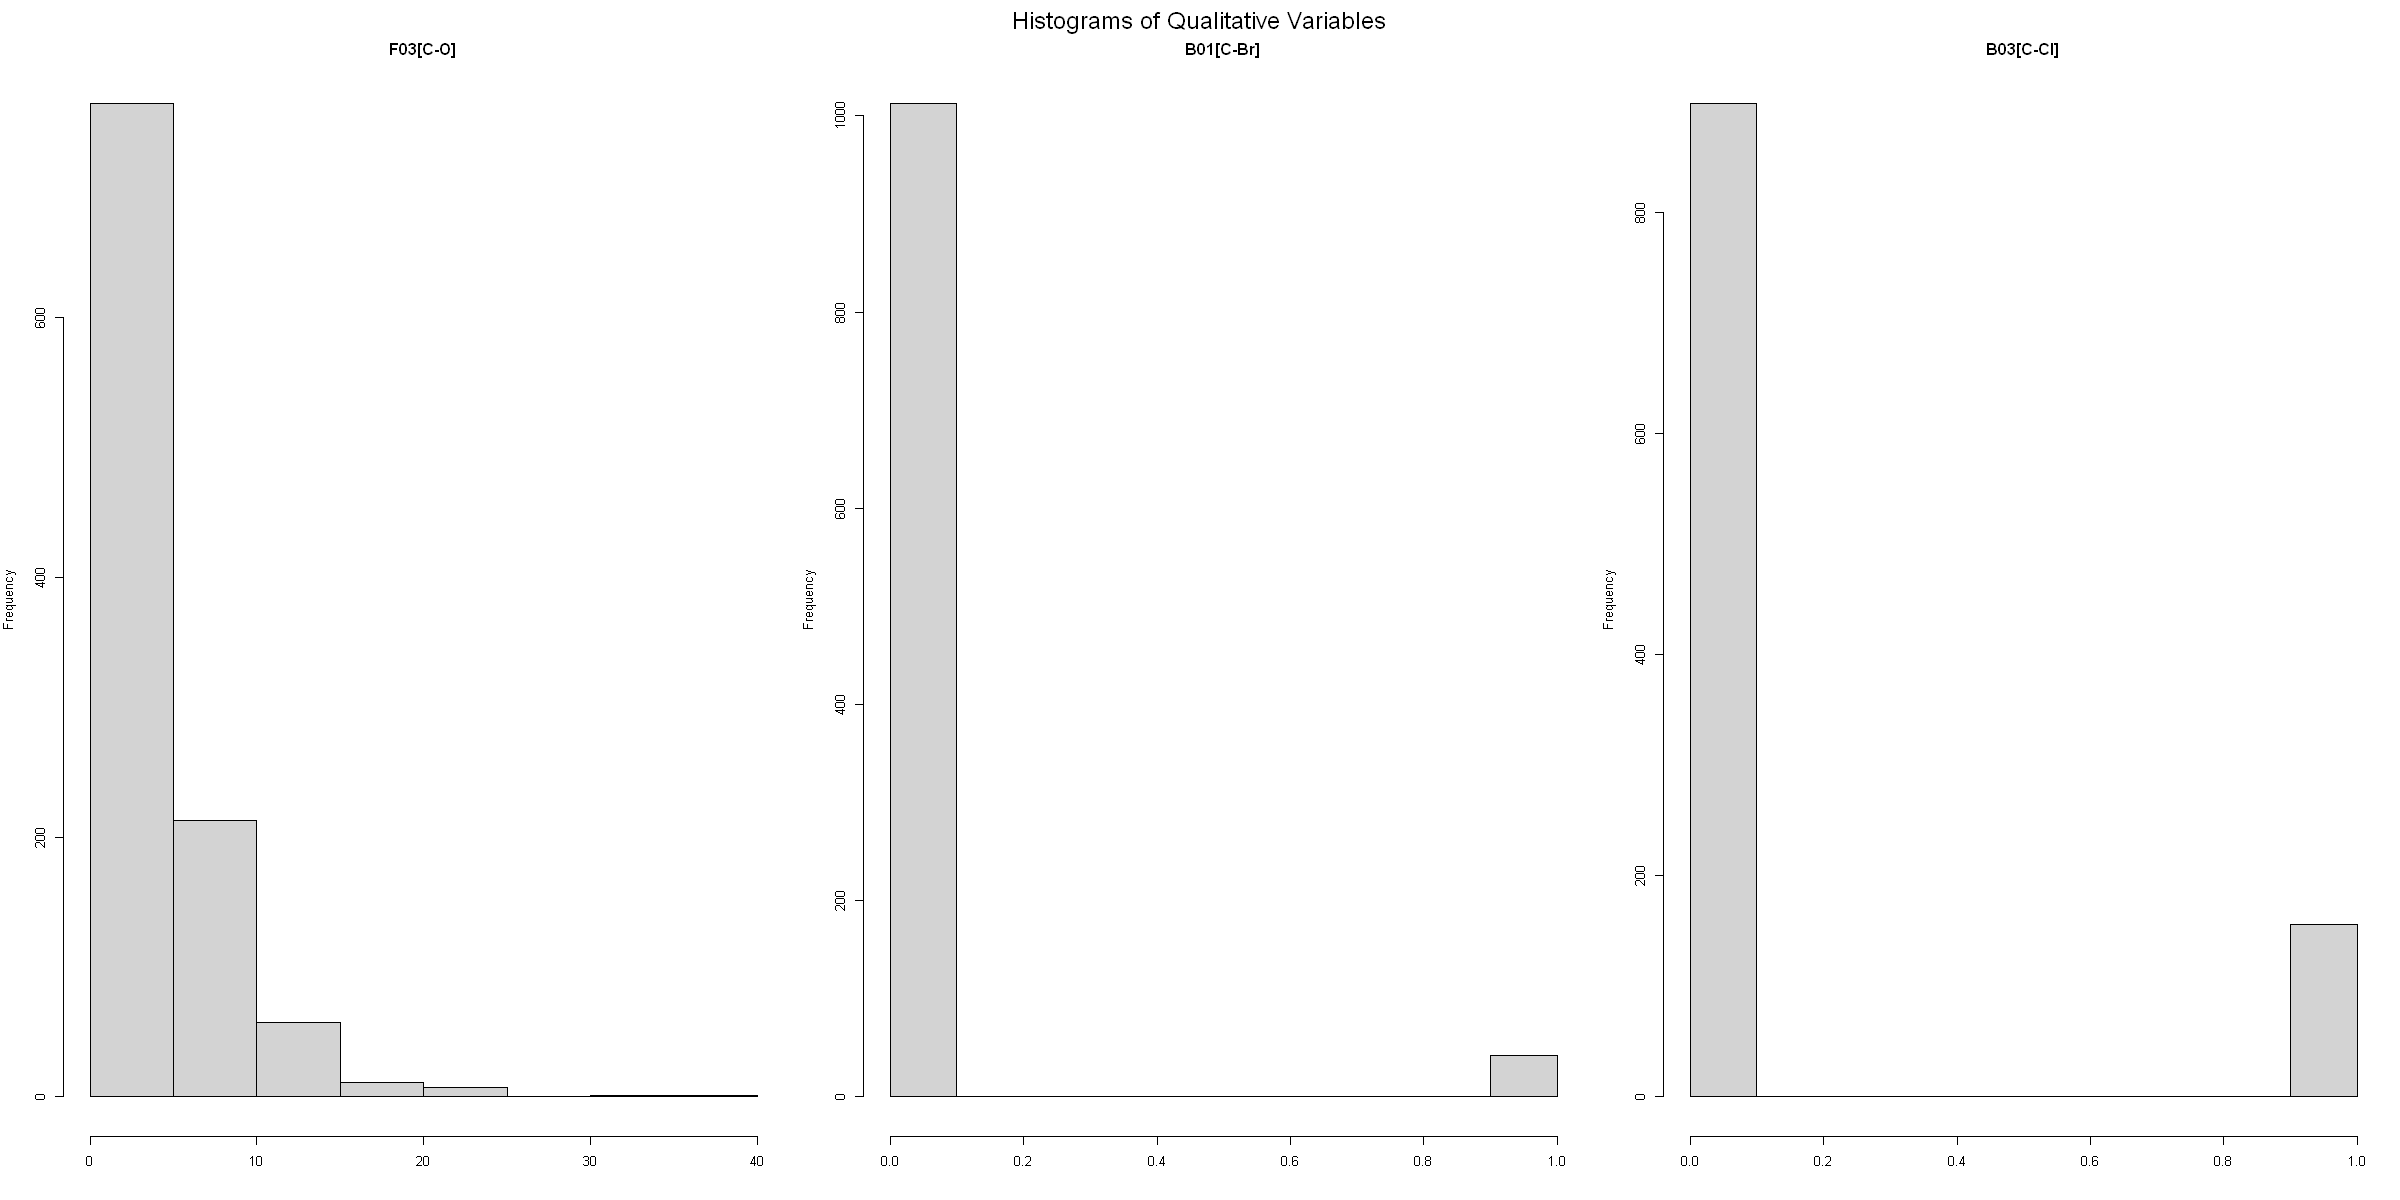

In [11]:
par(mfrow = c(1, length(quali_list)), mar = c(4, 4, 2, 1), oma = c(0, 0, 2, 0))
for (no in 1:length(quali_list)) {
  hist(data[[quali_list[no]]], main = quali_list[no], xlab = "")
}
mtext("Histograms of Qualitative Variables", outer = TRUE, cex = 1.2)

## Multidimensional

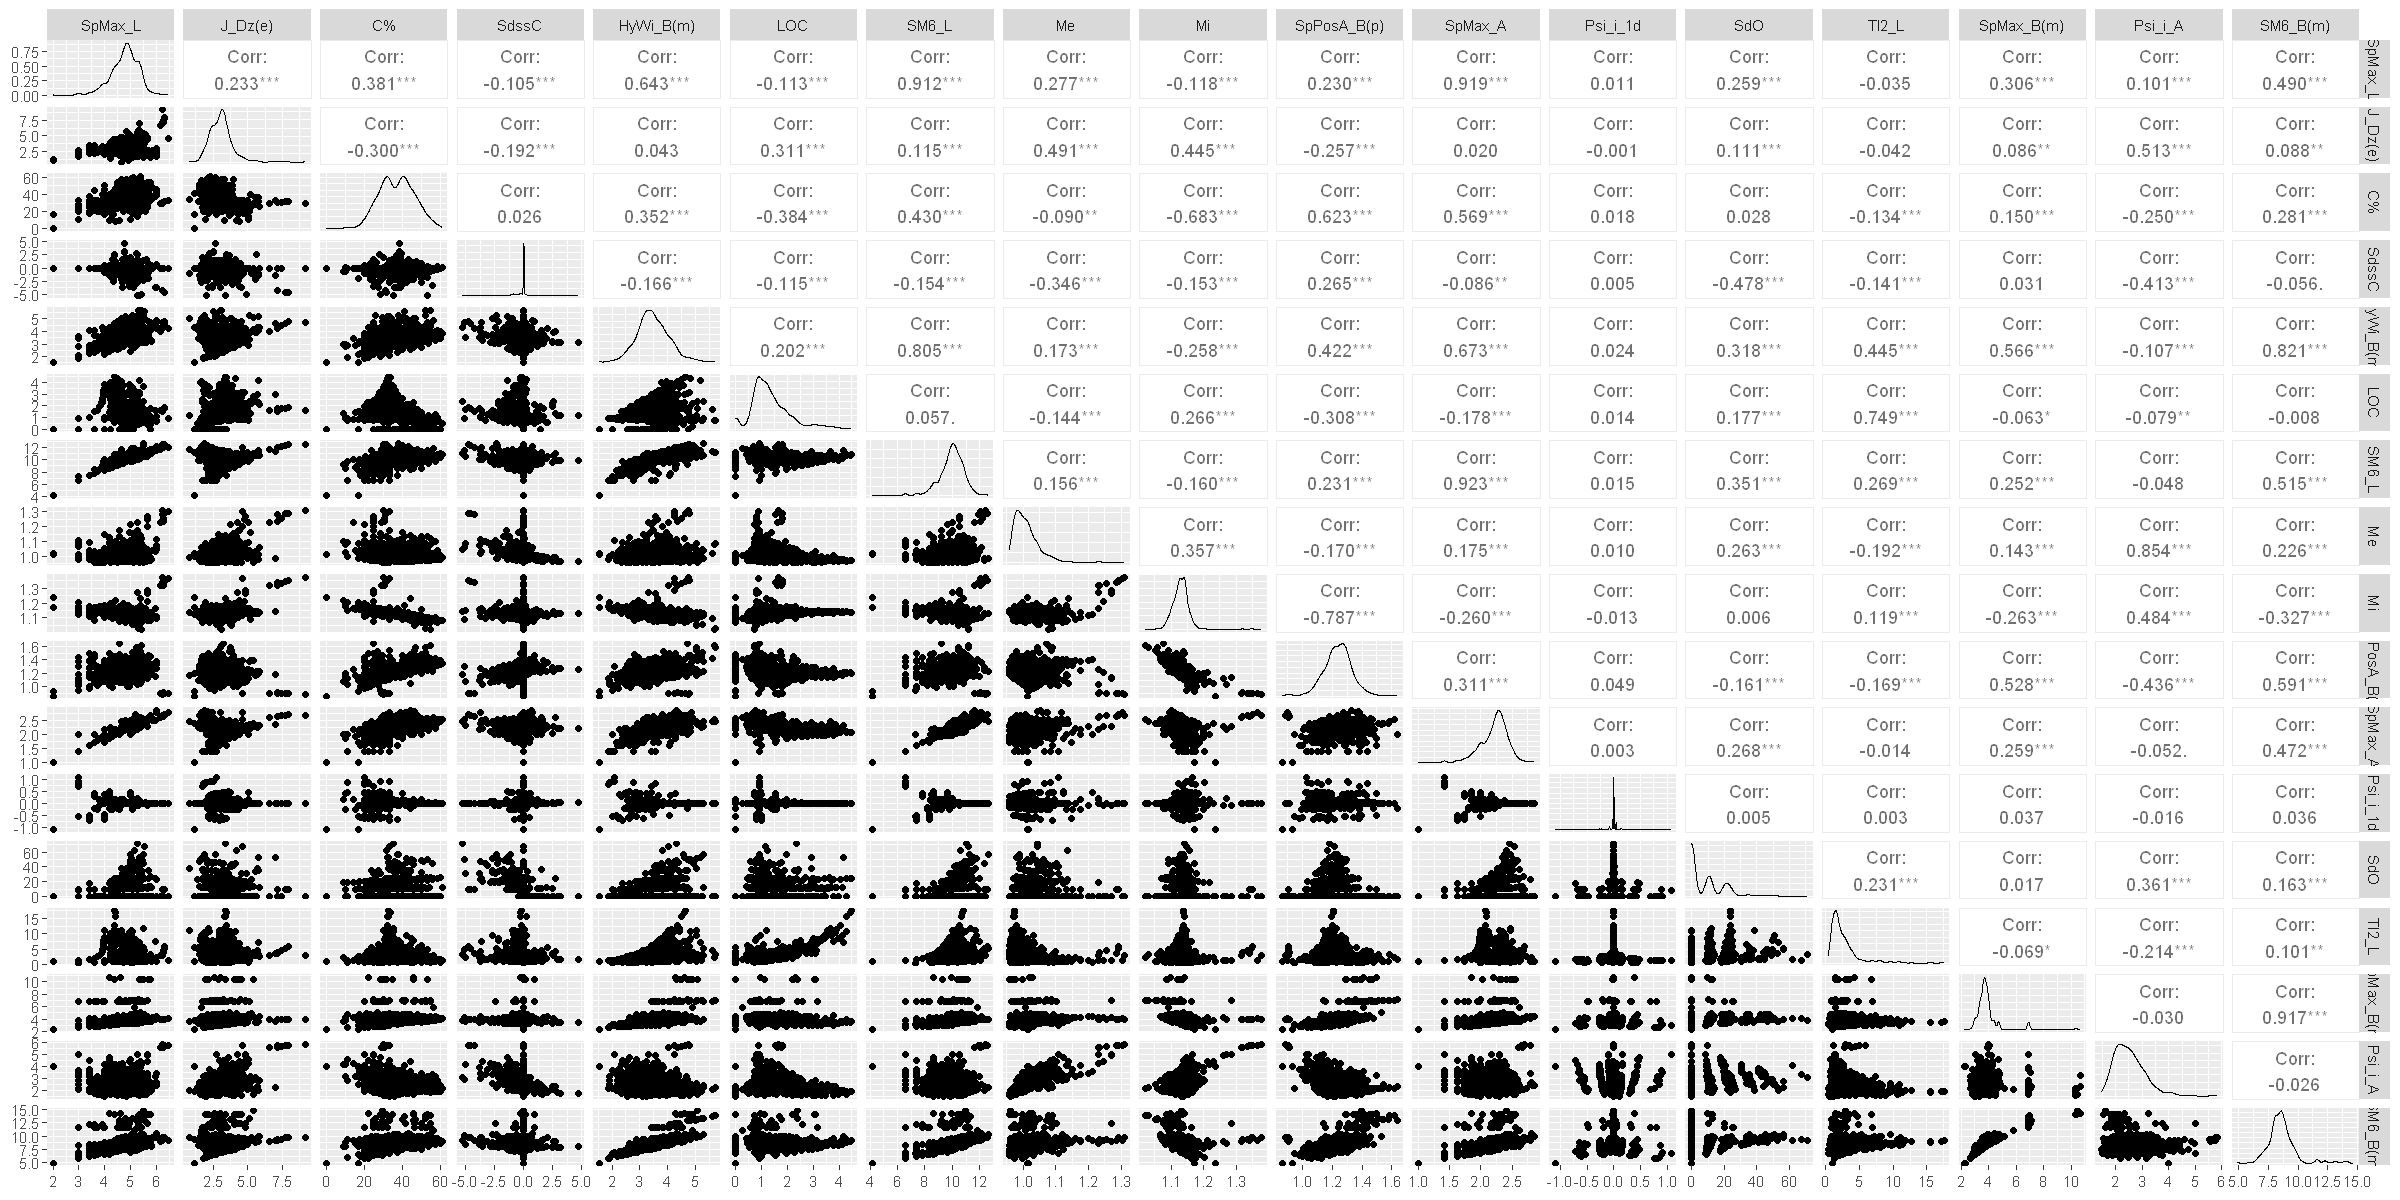

In [12]:
ggpairs(data[, quanti_index])

**Comment**: 

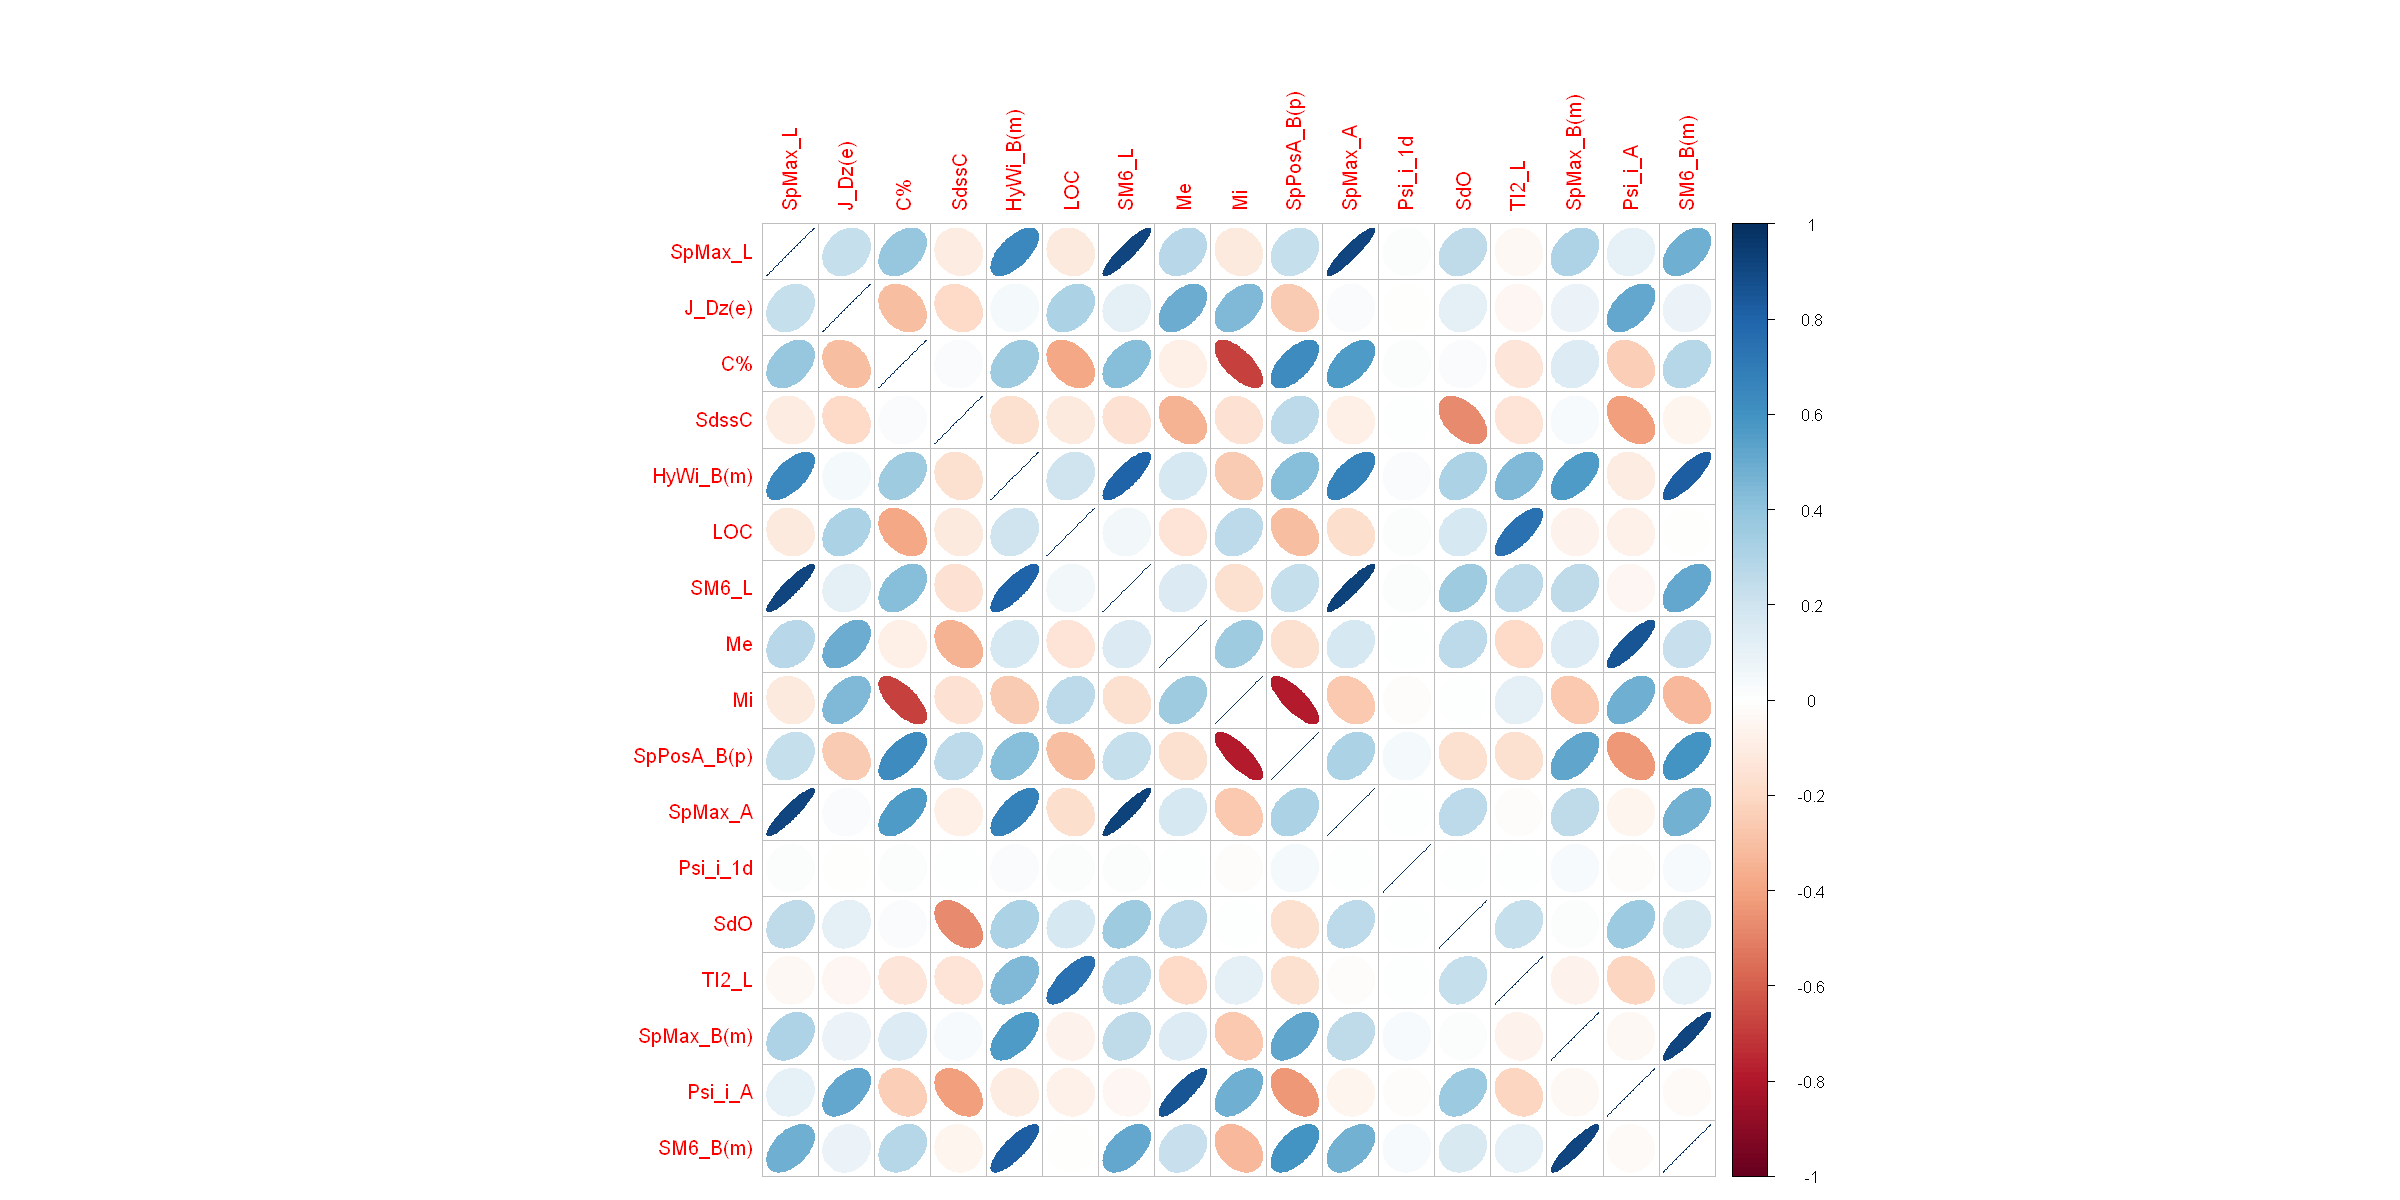

In [13]:
library(corrplot)
corrplot(cor(data[, quanti_index]),method="ellipse")

**Comment**: 

## Dependance between quantitative variables and response variable

In [14]:
# Data initial
data_non_biodeg <- data[biodeg$Response == 'NRB', ]
data_biodeg <- data[biodeg$Response == 'RB', ]

# Data transform
data_non_biodeg_transform <- data_transform[biodeg$Response == 'NRB', ]
data_biodeg_transform <- data_transform[biodeg$Response == 'RB', ]


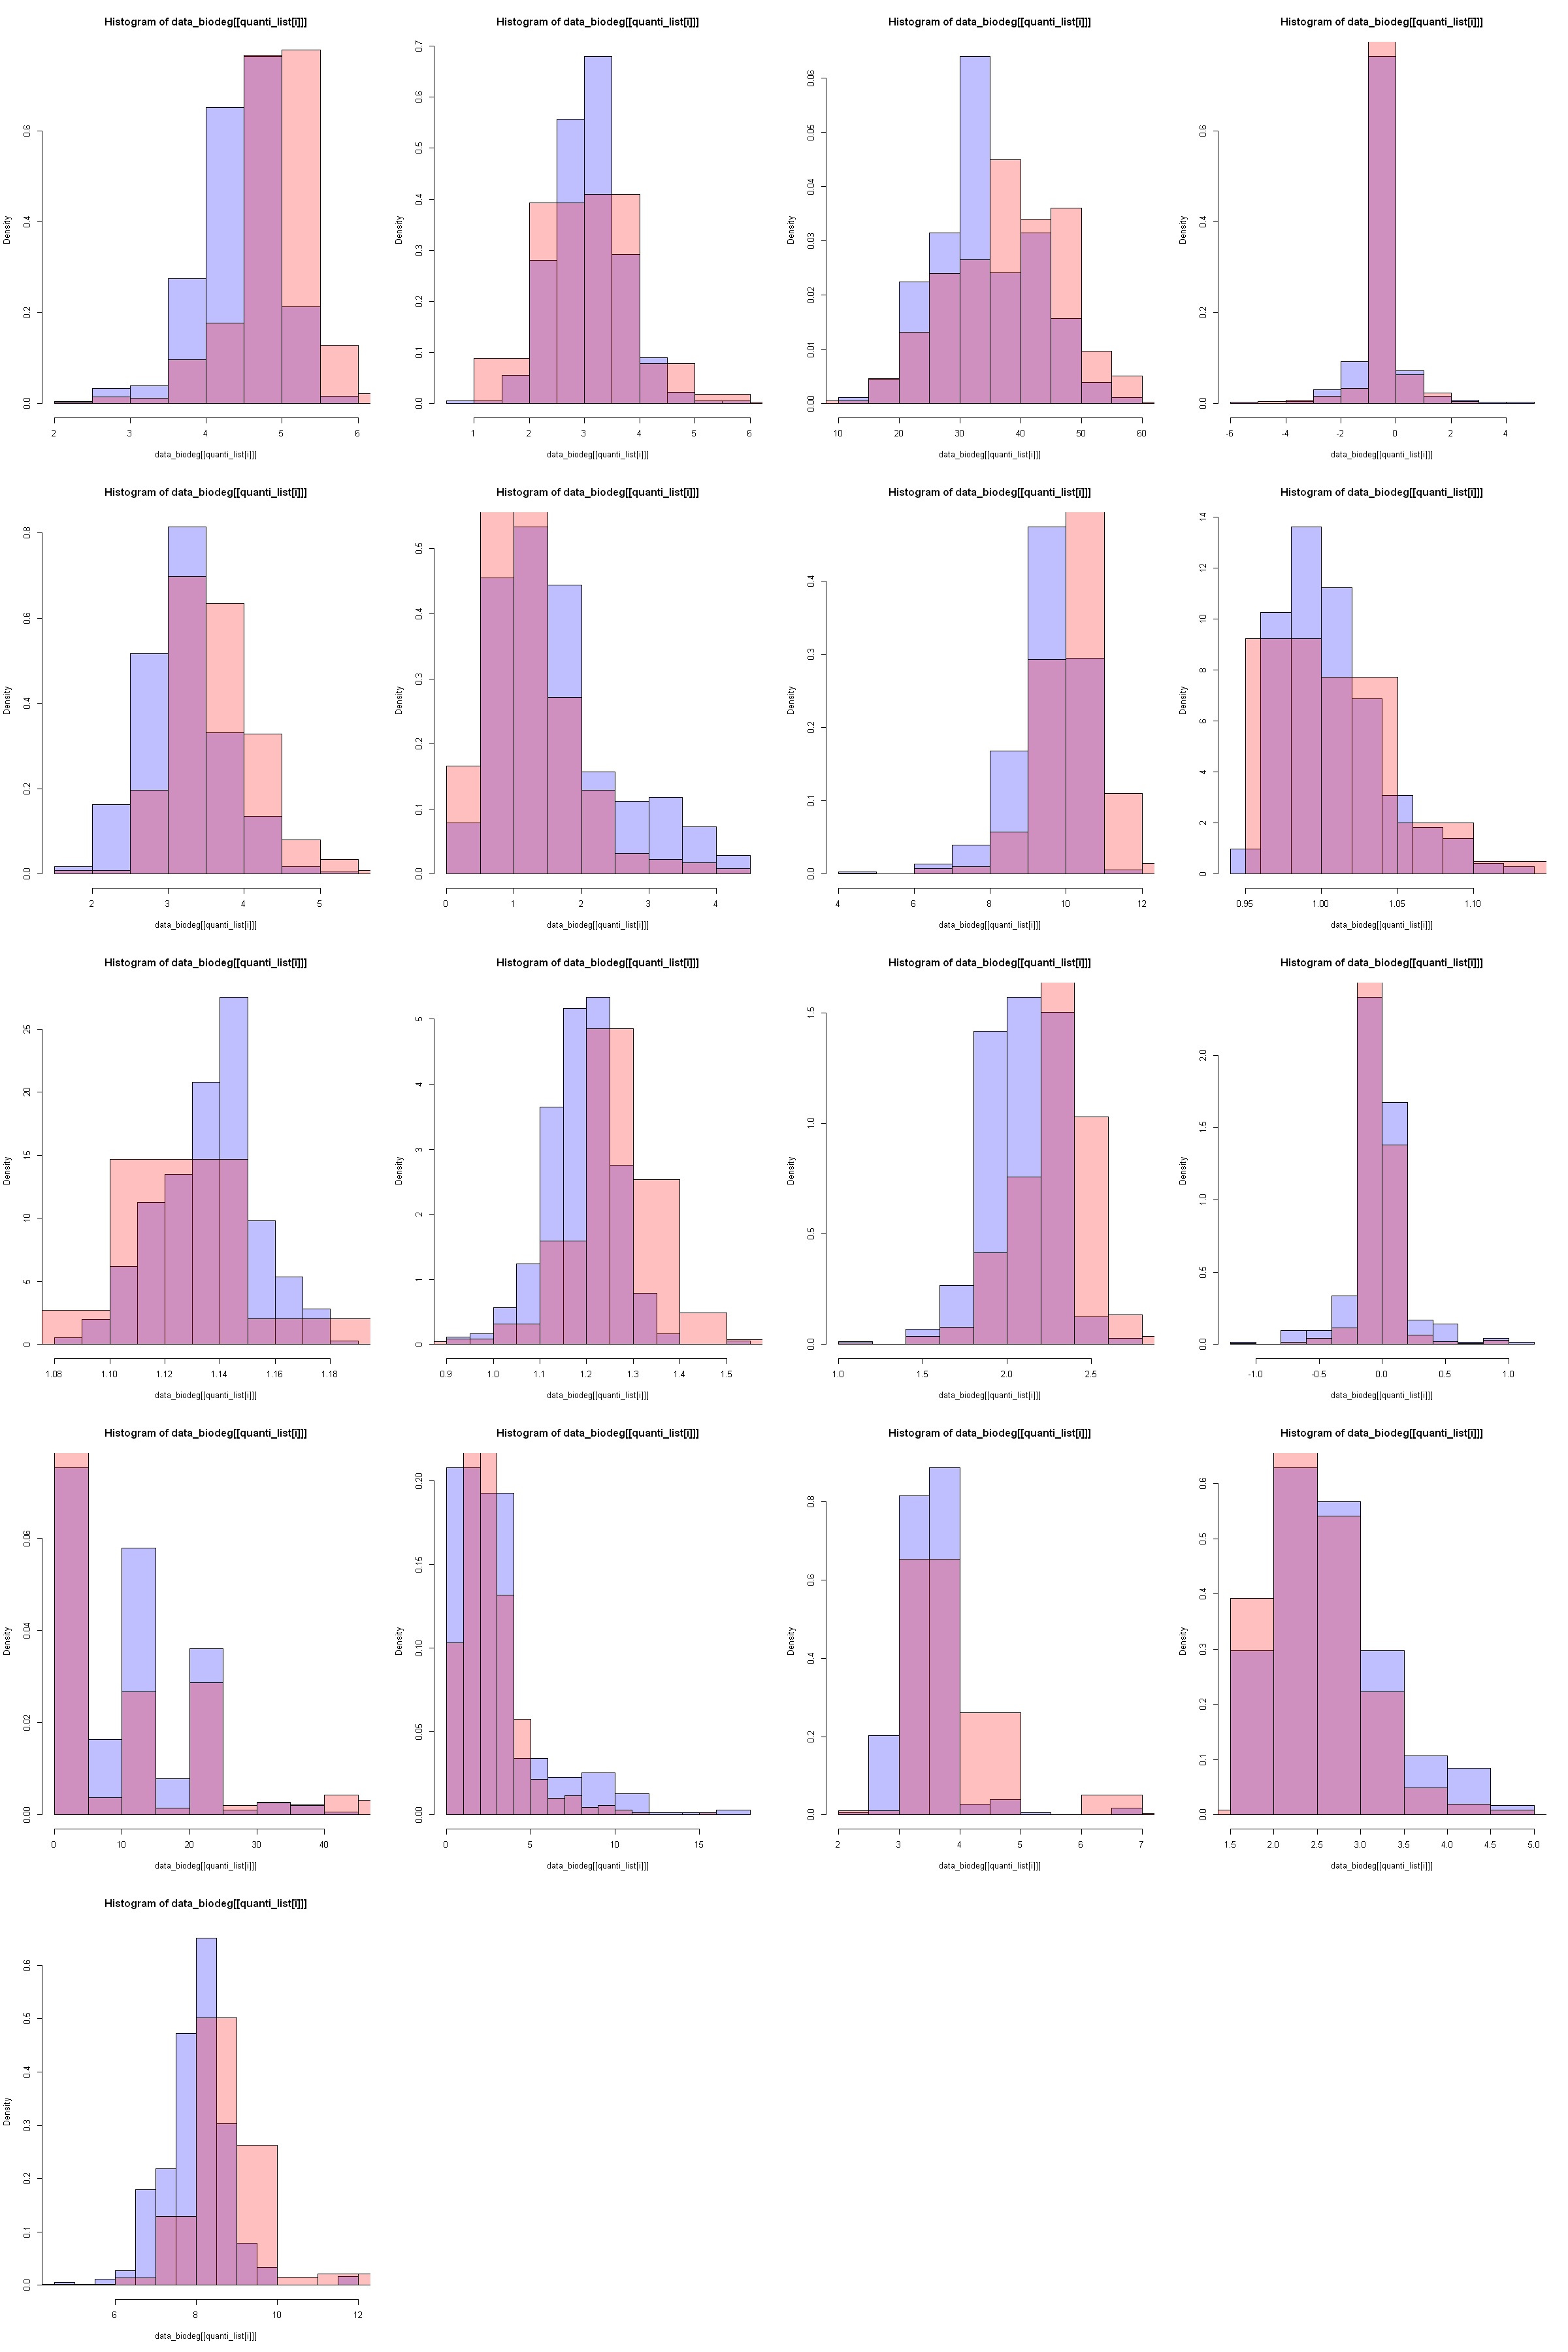

In [15]:
library(ggplot2)
options(repr.plot.width = 20, repr.plot.height = 30)

par(mfrow = c(5, 4))

for (i in 1:length(quanti_list)) {
    
    hist(data_biodeg[[quanti_list[i]]], col=rgb(0,0,1,1/4), prob = TRUE)
    hist(data_non_biodeg[[quanti_list[i]]], col=rgb(1,0,0,1/4), add = TRUE, prob = TRUE,main = quanti_list[i])
    
 }


Les variables quantitatives importantes déduites par les graphes au dessus : 
- SpMax_L
- C%
- SdssC
- HyWi_B(m)
- SpPosA_B(p)
- SpMax_A

## Dependance between qualitative variables and response variable

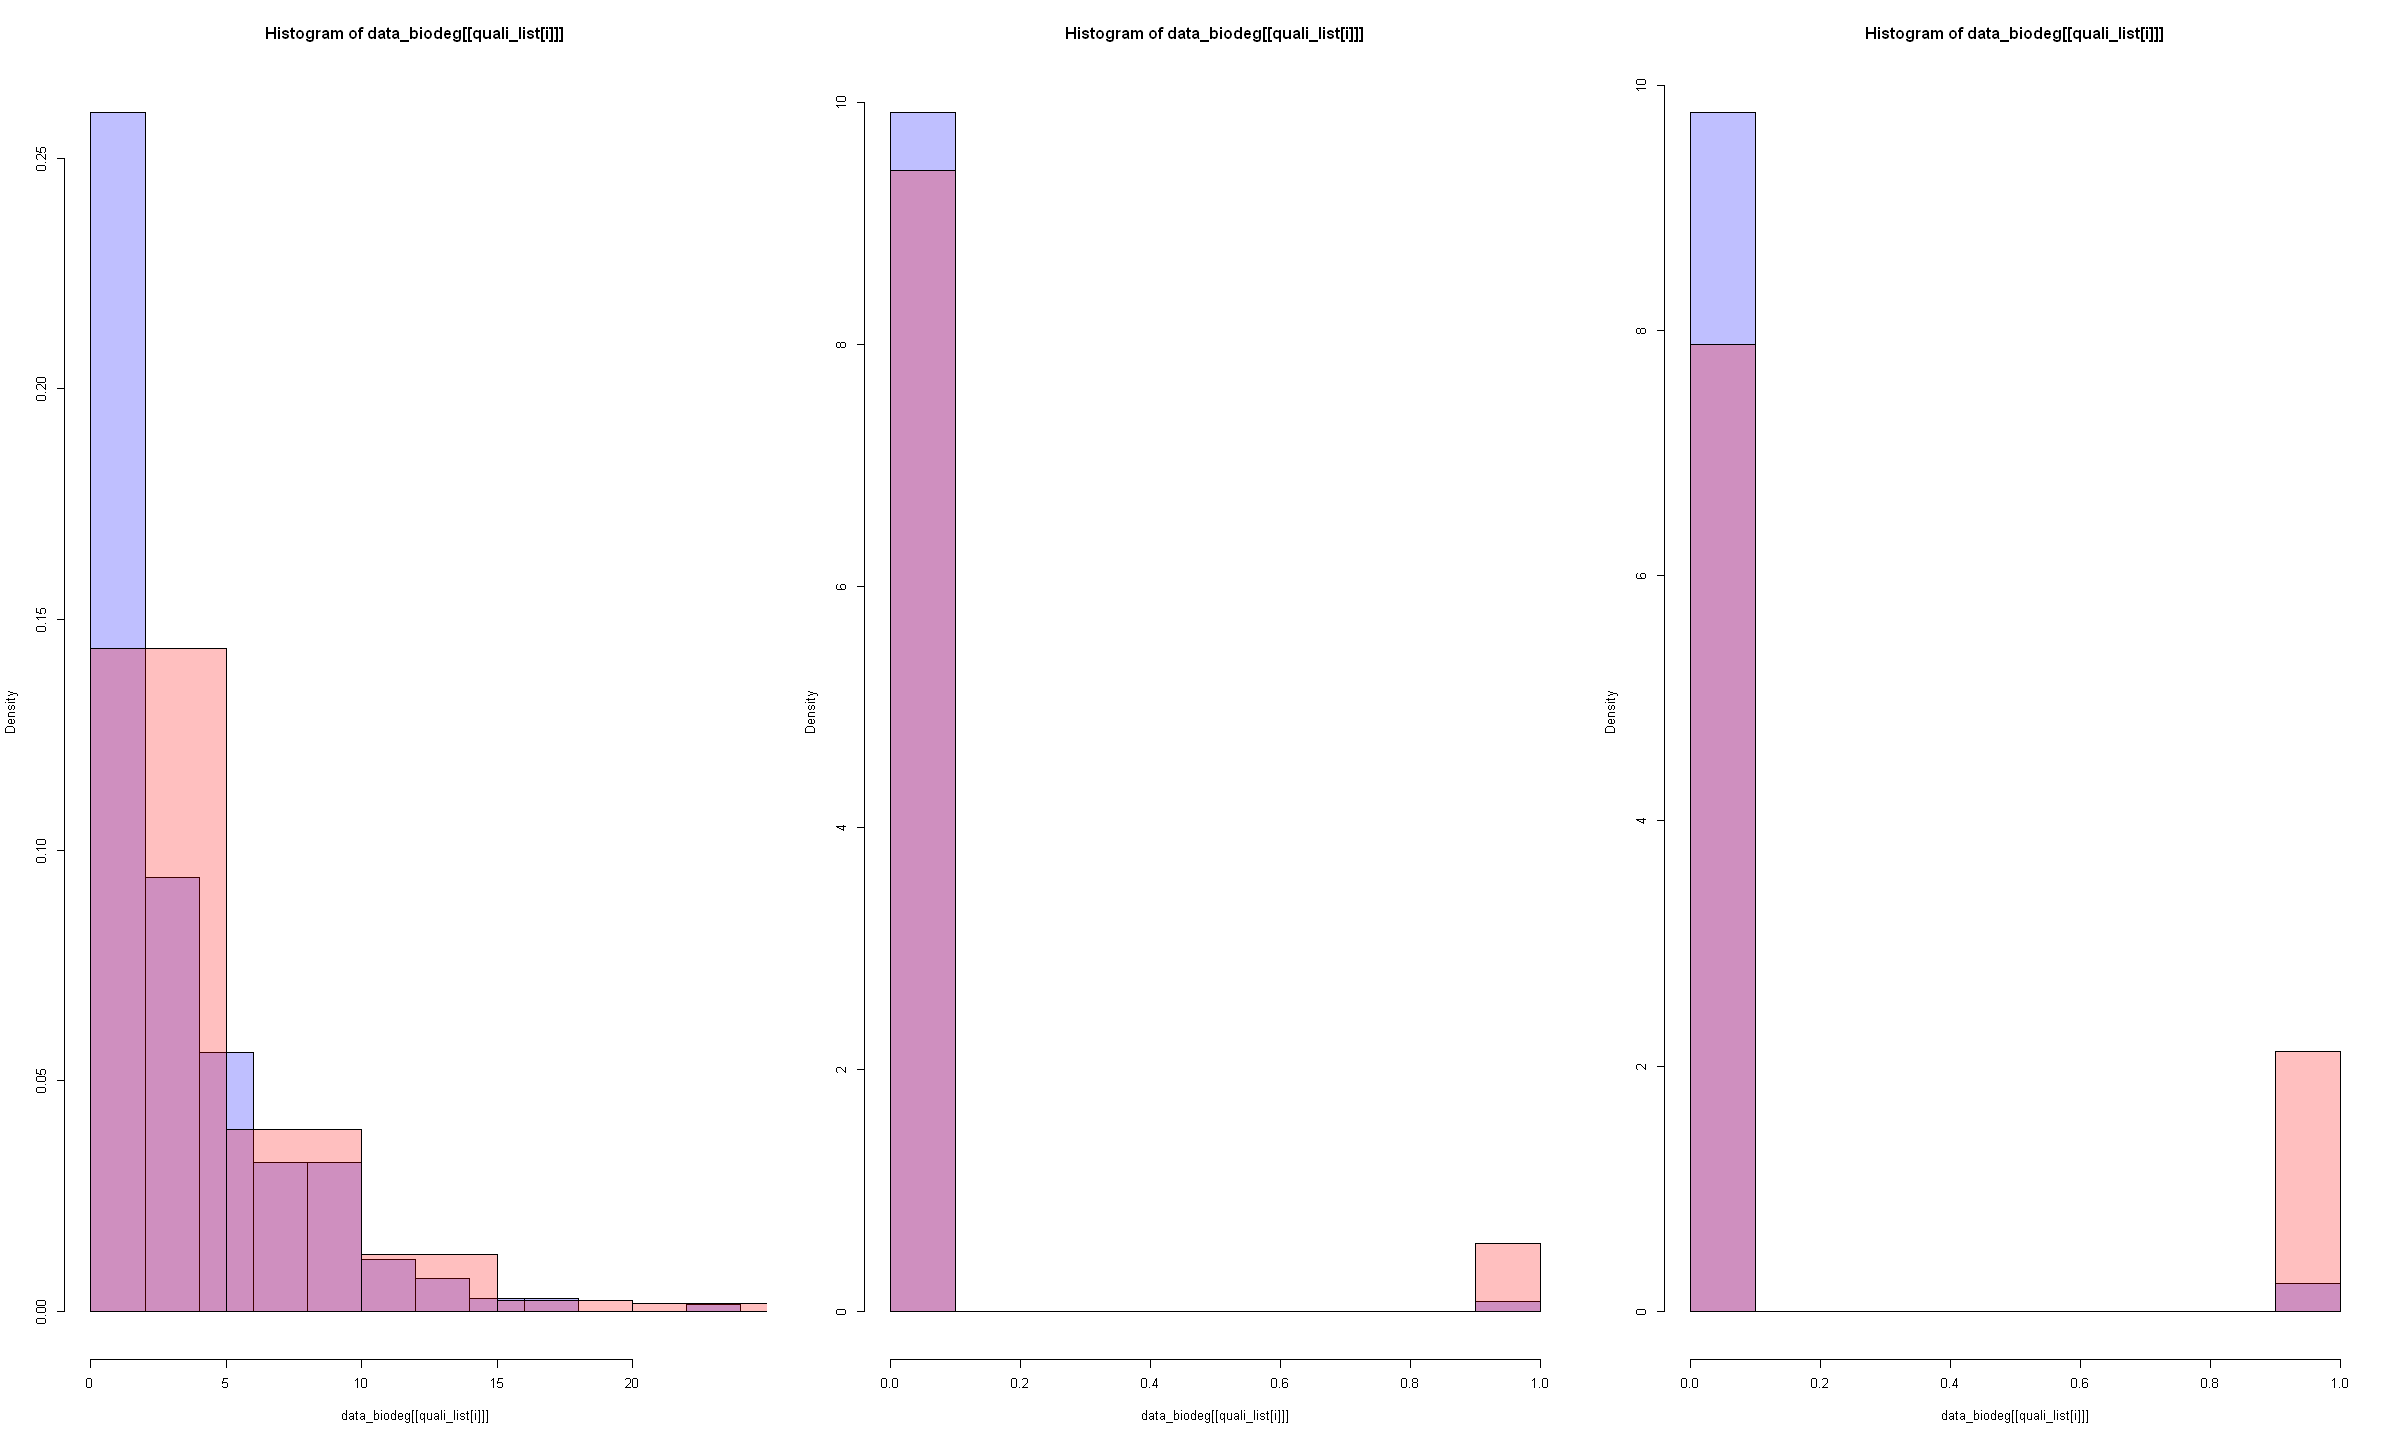

In [16]:
library(ggplot2)
options(repr.plot.width = 20, repr.plot.height = 12)

par(mfrow = c(1, 3))

for (i in 1:length(quali_list)) {
    hist(data_biodeg[[quali_list[i]]], col=rgb(0,0,1,1/4), prob = TRUE)
    hist(data_non_biodeg[[quali_list[i]]], col=rgb(1,0,0,1/4), add = TRUE, prob = TRUE,main = quanti_list[i])
    
 }

Pas de variables qualitatives importantes

In [17]:
data[,quali_index[1]][data[,quali_index[1]] > 0]

[1]  1  2  1  5  8  5  1  1  2  1  1  1  1  1  2  4  2  1  1  1  1  3  3 13  6
 [26]  8 10  3  4  5  6  5 10  6  4  2  2  2  3  2  2  3  4  3  1  4  6  4 10 14
 [51] 10 12  7  6  8  2  4 15  2  4  4  1  5  1  1  6  3  4  6 12  2  4  2  1  1
 [76] 12  2  1  1  2  2  1  2  2  6  6 17  2  1  5  8  4  4  8  6  8  2  7  6  6
[101]  4  5  3  1  4  1  1  2 10  6  2  4  4  4  2  2  6 16 10 13 12 10  4  8 10
[126] 18  4  4  9  7  8  8  6  2  4  6  2  2  6  2  8  9  9  1  1  1  2  1  6 10
[151]  8  4  1  5  4  4  2  5  4 10  2  1  3  3  1  2  4  2 12  8  9 12  4  1  1
[176]  2  6  3  4  3  7  3  2  1  1  2  5  3  4  2  4  6  2 23  3  9  1  4  2  2
[201]  2  2 12 14  8 10  3  3  2  2  4  8  4  8  3  4  4  2  2  8  9  9  8  2  2
[226]  4 14  7  8  4  3  4  2  8  4  6  8  8  4  4  2  3  2  6  5  4  8  6  6 16
[251]  6  6  2  2  4  9  6  2 12  4  4  8  4  8  8  8  4  4  8  4  4  2  3  2  2
[276]  3  3  3  4  3  3  4  6  2  3  6  5  6  6  6  7 11  2  2  2  2  2  5  2  2
[301]  2  2  2  2  2  6  4  4  2 12  6  6  2  5 12  2  8 11  4  6  6  8  4 10  9
[326]  4  3  8  4 10  3  4  2  8 14 32  1  4  6  6  6  2  6  8  3  6  9  3  2  6
[351] 10  4  8 15 18  8 10  3  9  9 15  4 12 40  6  6 12  8  4 12  8 12 18  8  8
[376] 12  2  6  2  6 24  6  5  6  6  6  2  4  2  6  9  4  2 14 24  3  4  2  4  2
[401]  6 12  8  6  3 18  8  4  4  4  4  4  4  2  4 10 12  3  6  2  4 10  5  4  2
[426] 18 15  7 12  2  2  4  3  4  3  6  9 11  8  8 11 11  8  3  2  2 12  6 12  8
[451]  8 11  3 15  2  1  4  1  6  9 12  1  3  2  4  2  2 24  1  6 18 21  5  1 16
[476] 24  7  5  2  9 10 10  6  9  6  8  4  5  9  4  3  2  3  8  8  4  4  4  4  2
[501]  3  6 14  2  7  2  5  2  1 12  4  8  8  8  3 11  8  3  4  4  7  8  9  6  9
[526]  9 13  4  2 12  6 14  9  9  9  7  9  4  4  2  1  1  2  6 10  4  4  2  6  4
[551]  4 10  2  6  4  6  1  1  2  1  4  3  6  2  6  5  7  1  2  3  4  2  3 10  6
[576]  6  2  2  3  4  3 10  6  1  8  7 12 14  2  9  3  3  3  2  1  4  6  4  2  4
[601] 12  9  8  1  7  2  2  3 10  3  2  2  4 12 10  3 15  2  3  8  8  4  6  4  4
[626]  4  2  1  6  1  5  4 15  4  8  8  6 12 10  2  1  3  9  2 12  3  8  6  6  2
[651] 16  6  2  4 11  4 12  4  8  8  5  1  1  4 12  2  1  4  4  4  2  2  2 11  6
[676] 10  2 21  9

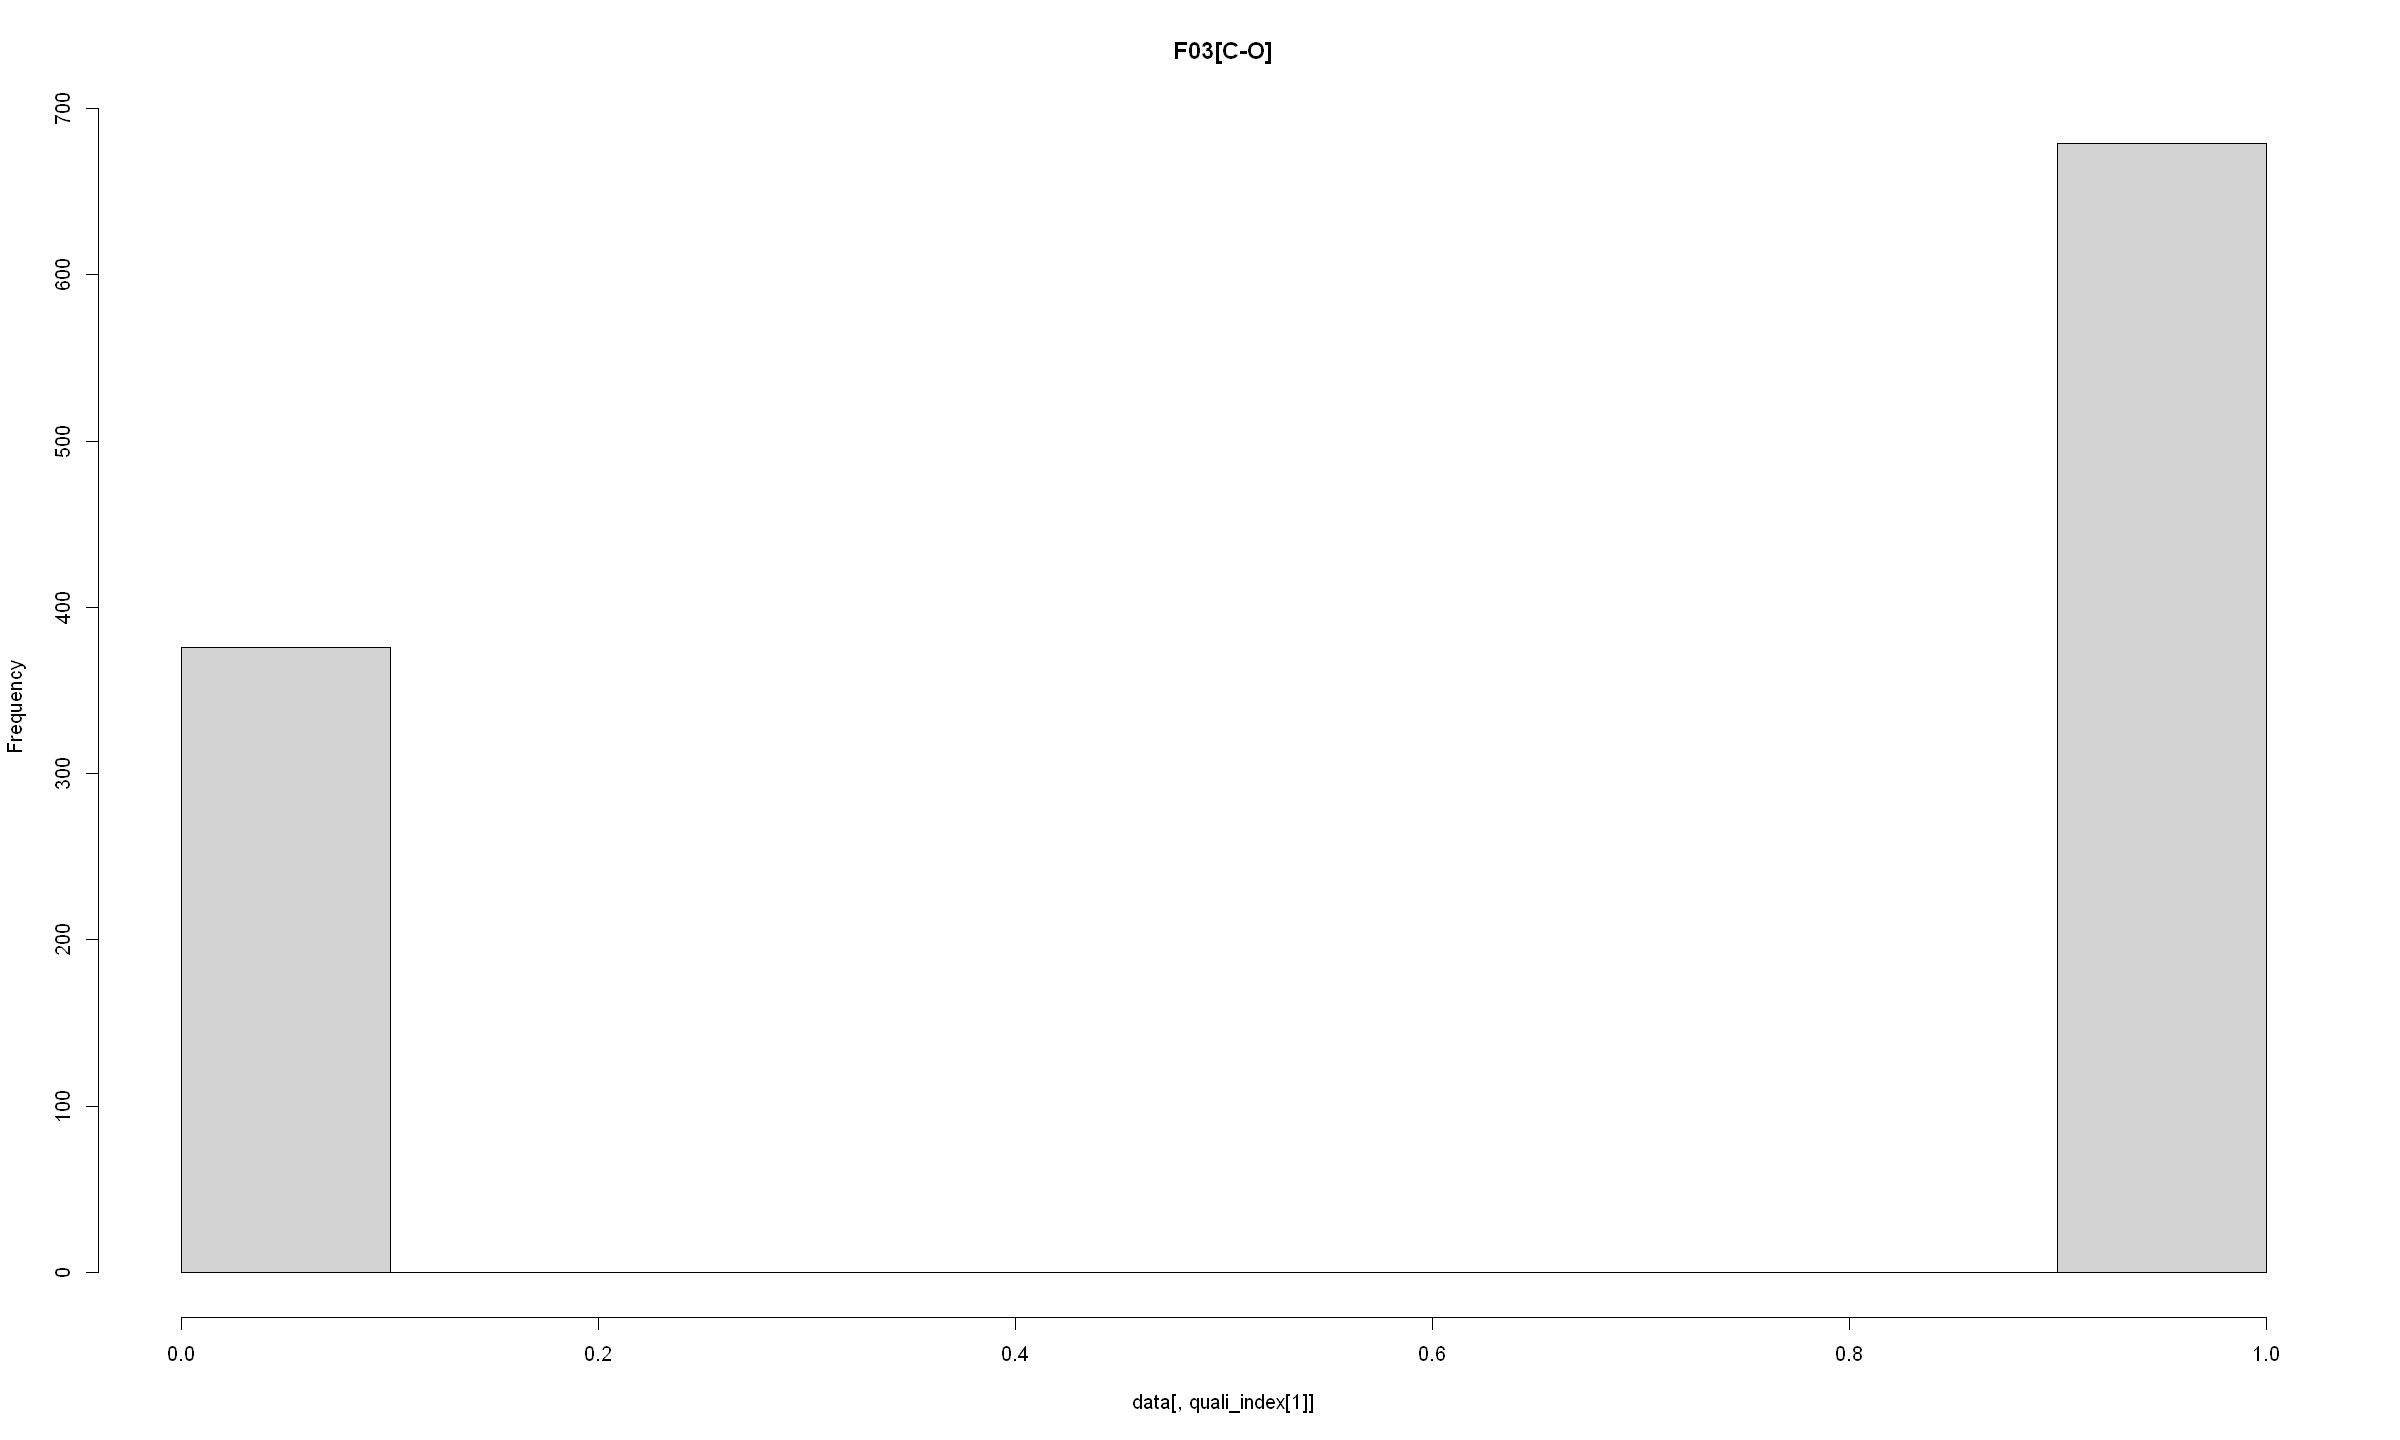

In [18]:
data[,quali_index[1]][data[,quali_index[1]] > 0] <- 1 
hist(data[, quali_index[1]], main=quali_list[1])
data_transform[, quali_index[1]][data_transform[, quali_index[1]] > 0] <- 1 


In [19]:
data$'F03[C-O]' <- factor(data$'F03[C-O]', ordered = TRUE)
data$"B01[C-Br]" <- factor(data$"B01[C-Br]")
data$"B03[C-Cl]" <- factor(data$"B03[C-Cl]")

data_transform$'F03[C-O]' <- factor(data_transform$'F03[C-O]', ordered = TRUE)
data_transform$"B01[C-Br]" <- factor(data_transform$"B01[C-Br]")
data_transform$"B03[C-Cl]" <- factor(data_transform$"B03[C-Cl]")

## 2.4. Principal Component Analysis

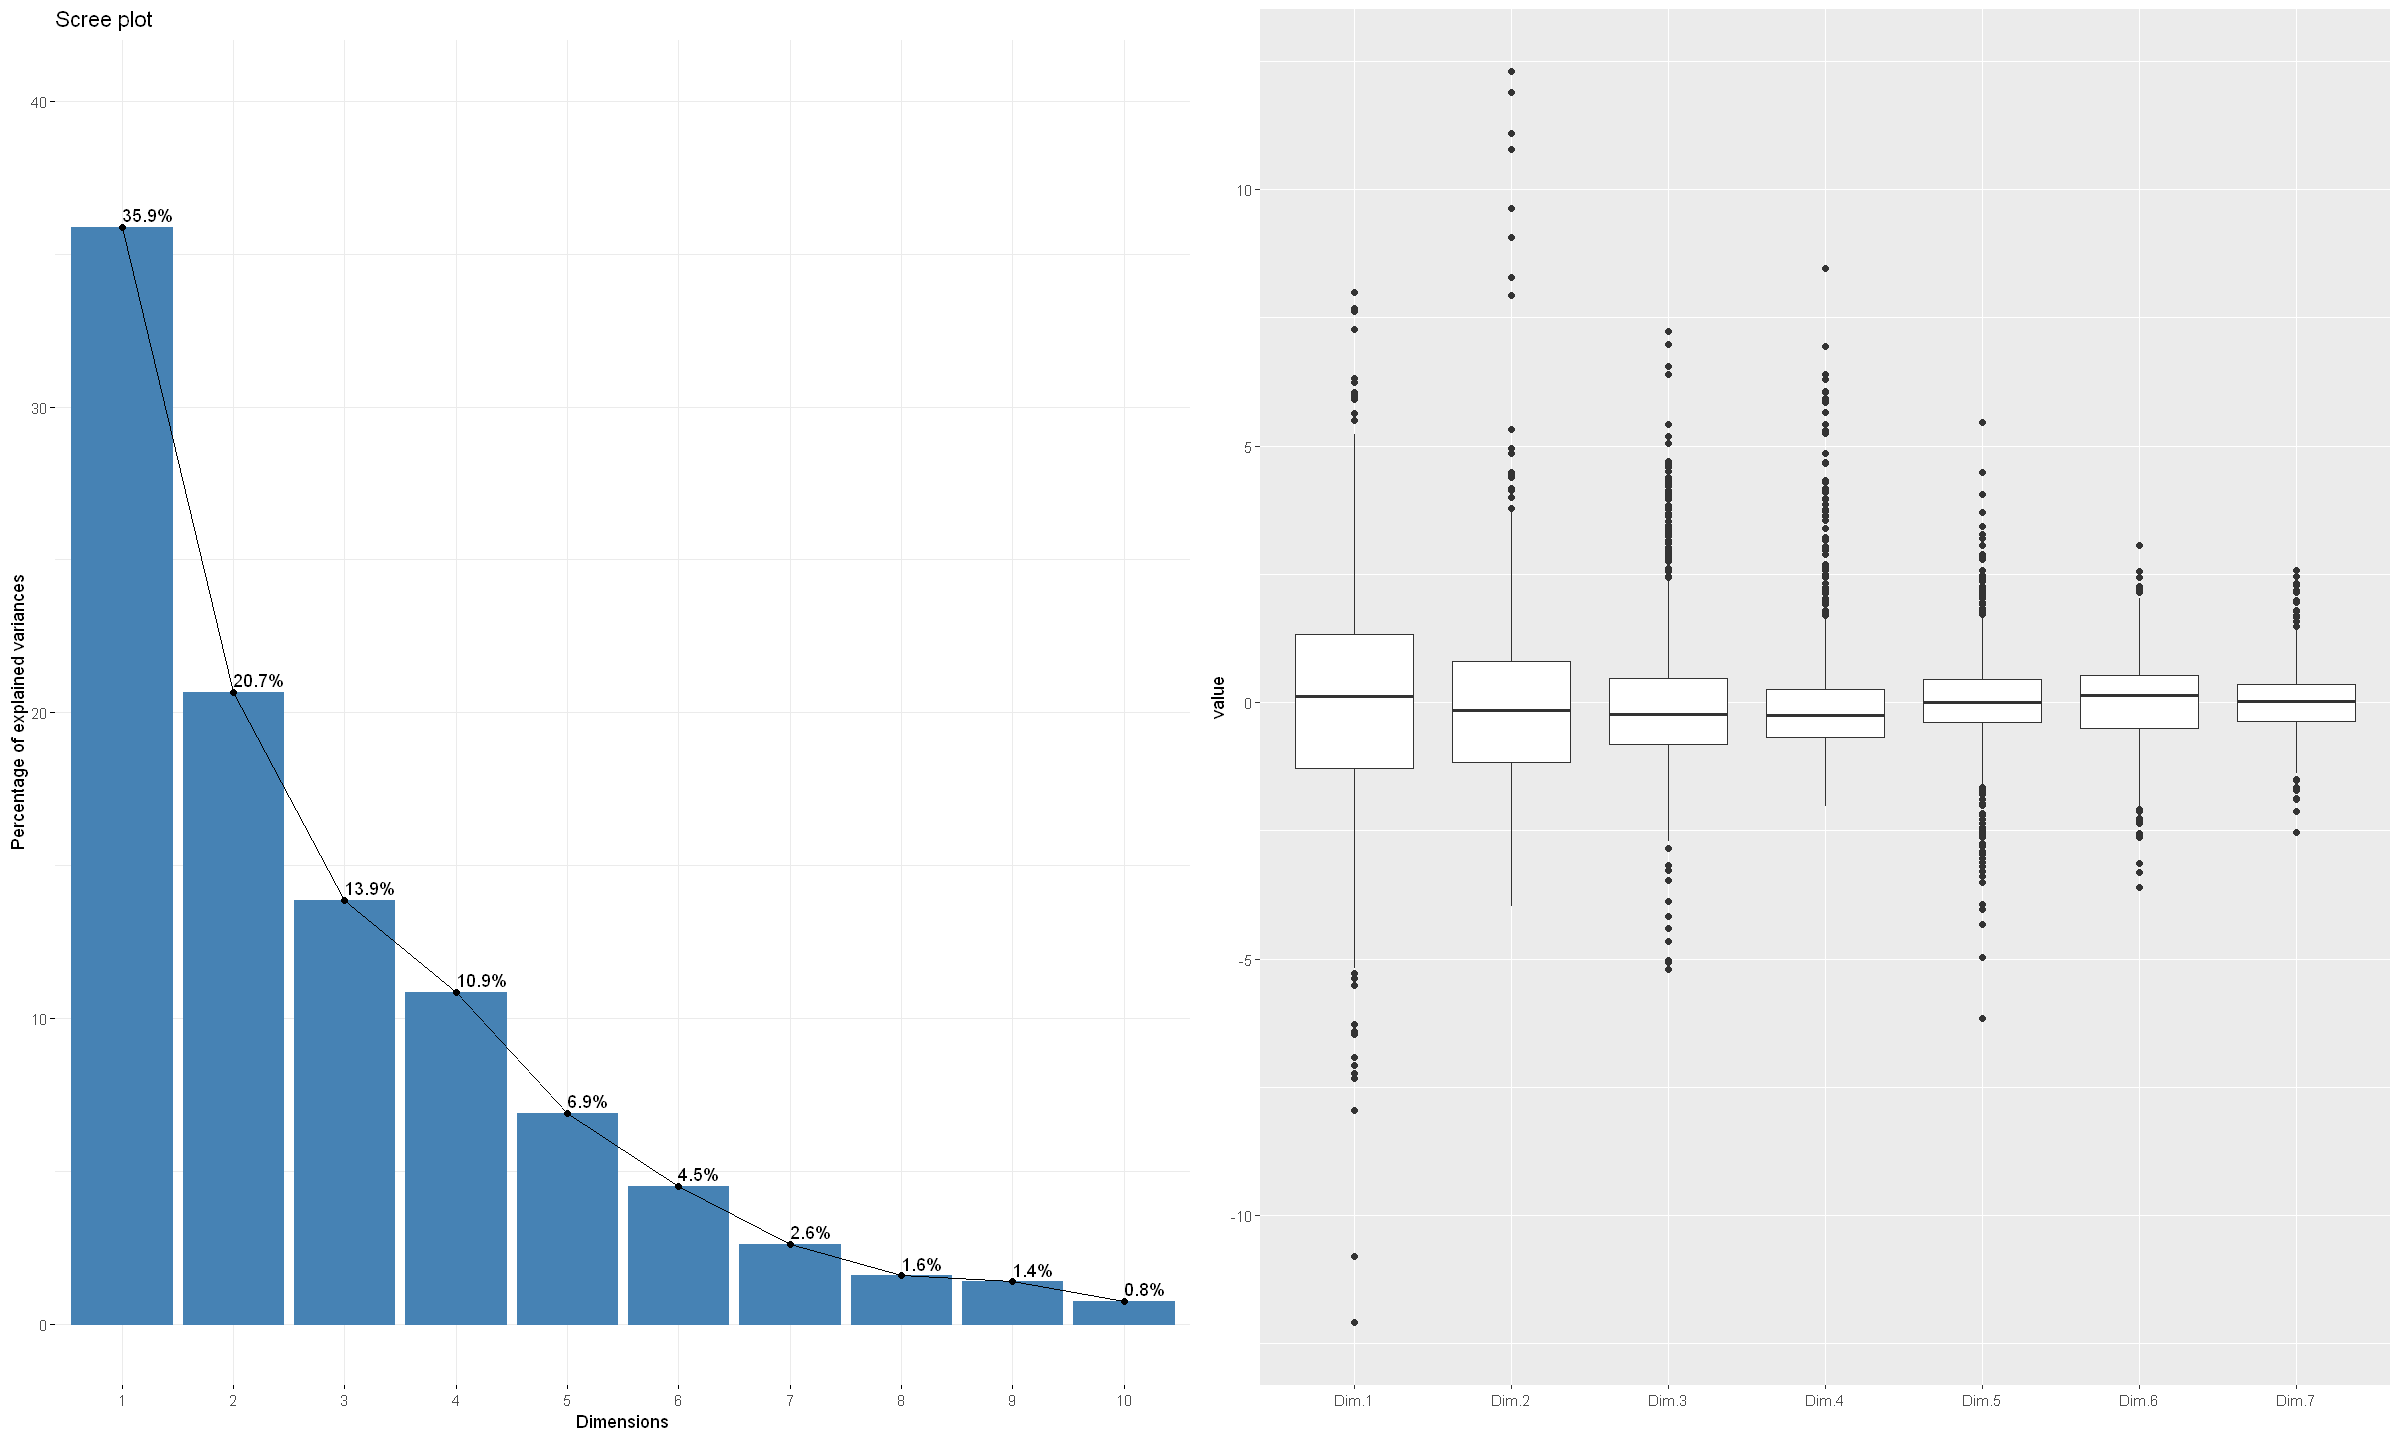

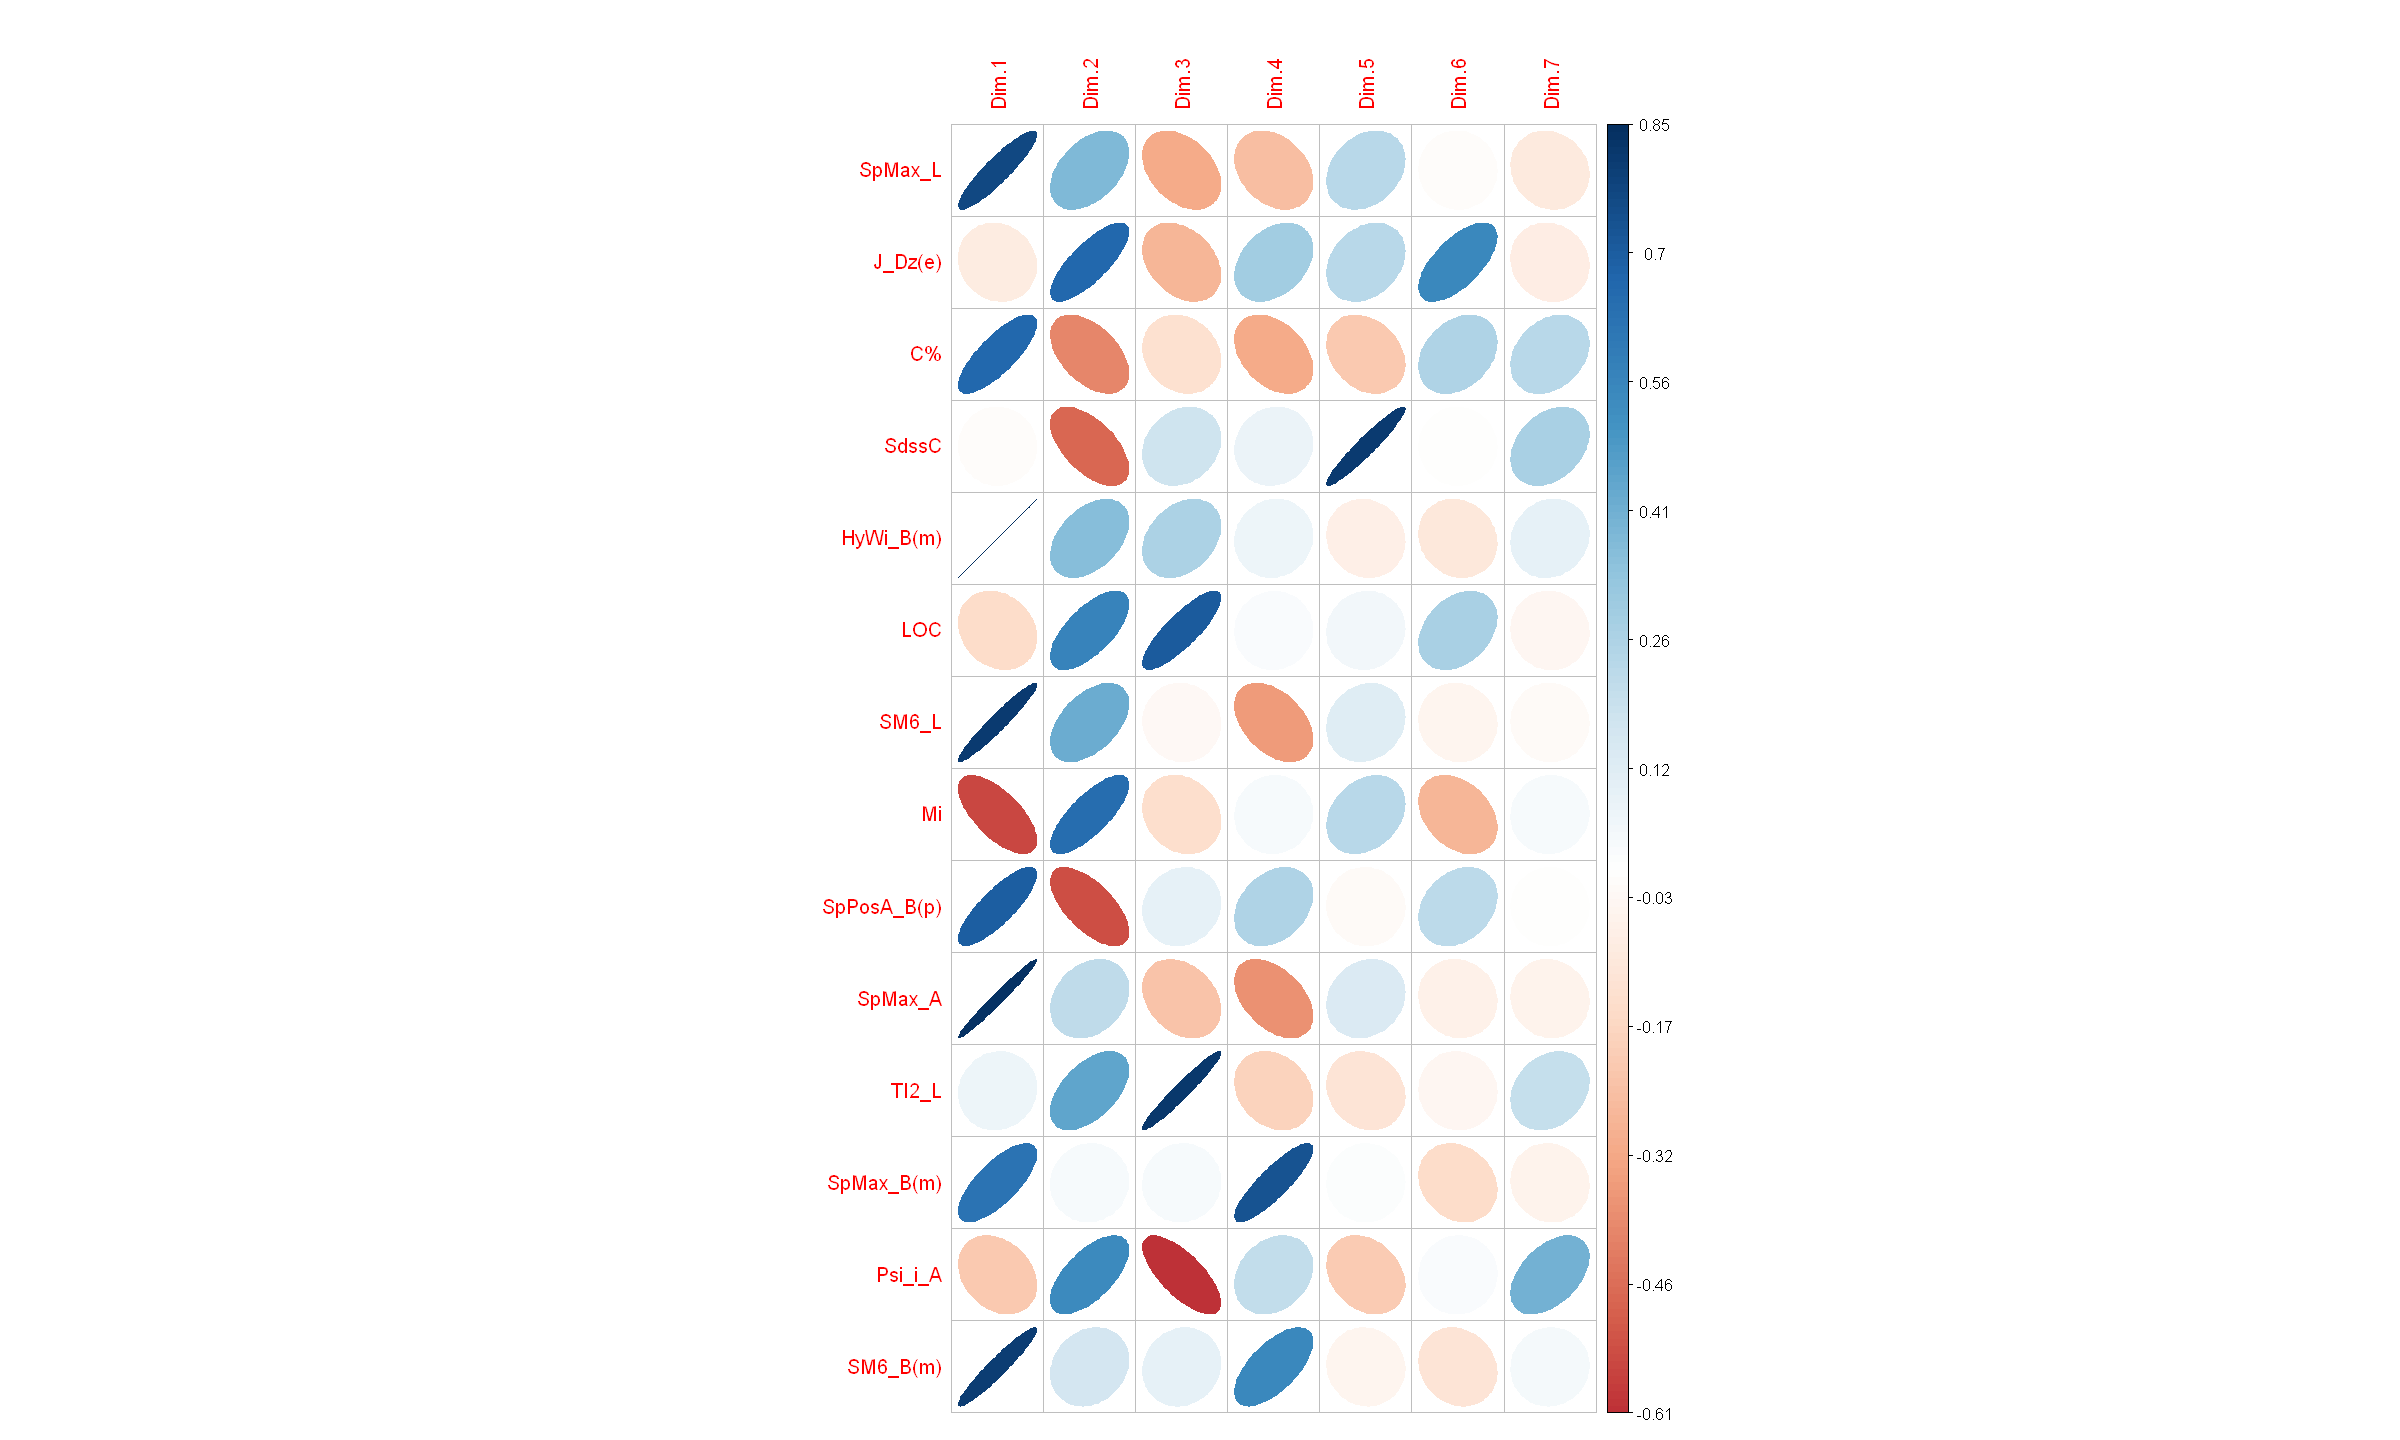

In [20]:
# ACP réduite
library(FactoMineR)
acp <- PCA(data[, quanti_list], scale.unit = TRUE,
           graph = FALSE, quali.sup = quali_index, ncp = 7)
# Décroissance des valeurs propres
library(factoextra)
g1<-fviz_eig(acp, addlabels = TRUE, ylim = c(0, 40))
library(reshape2)
g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)
# 
library(corrplot)
corrplot(acp$var$cor, is.corr=FALSE,method="ellipse")

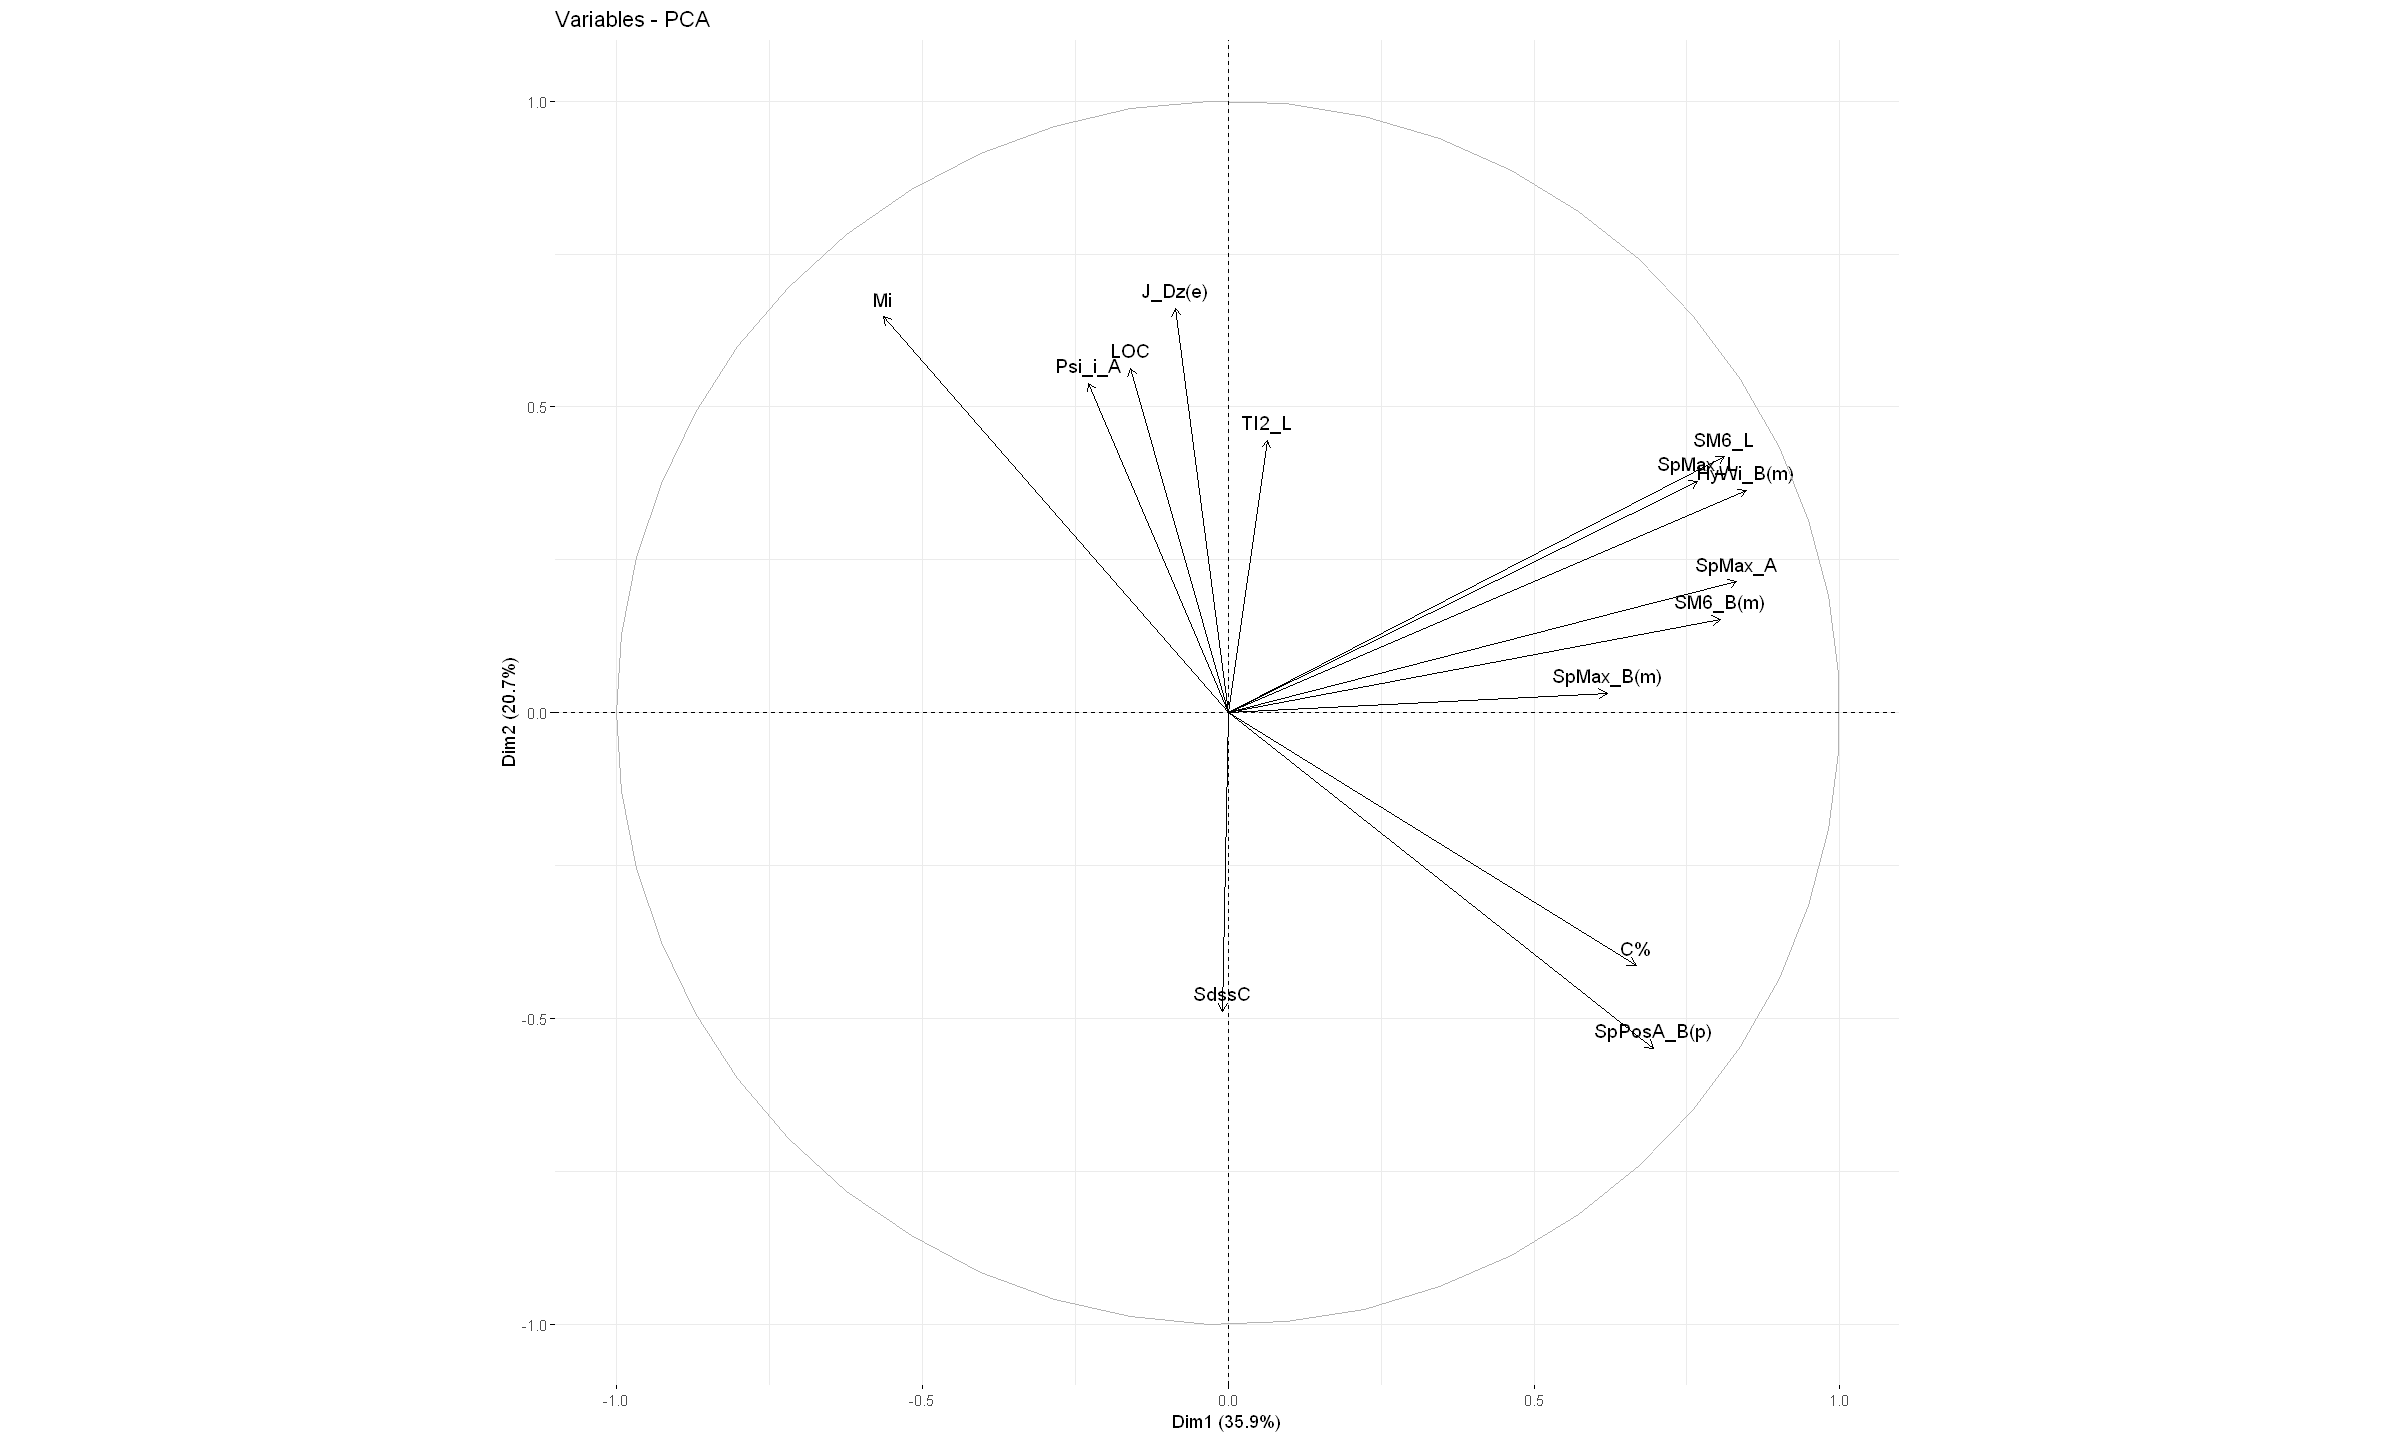

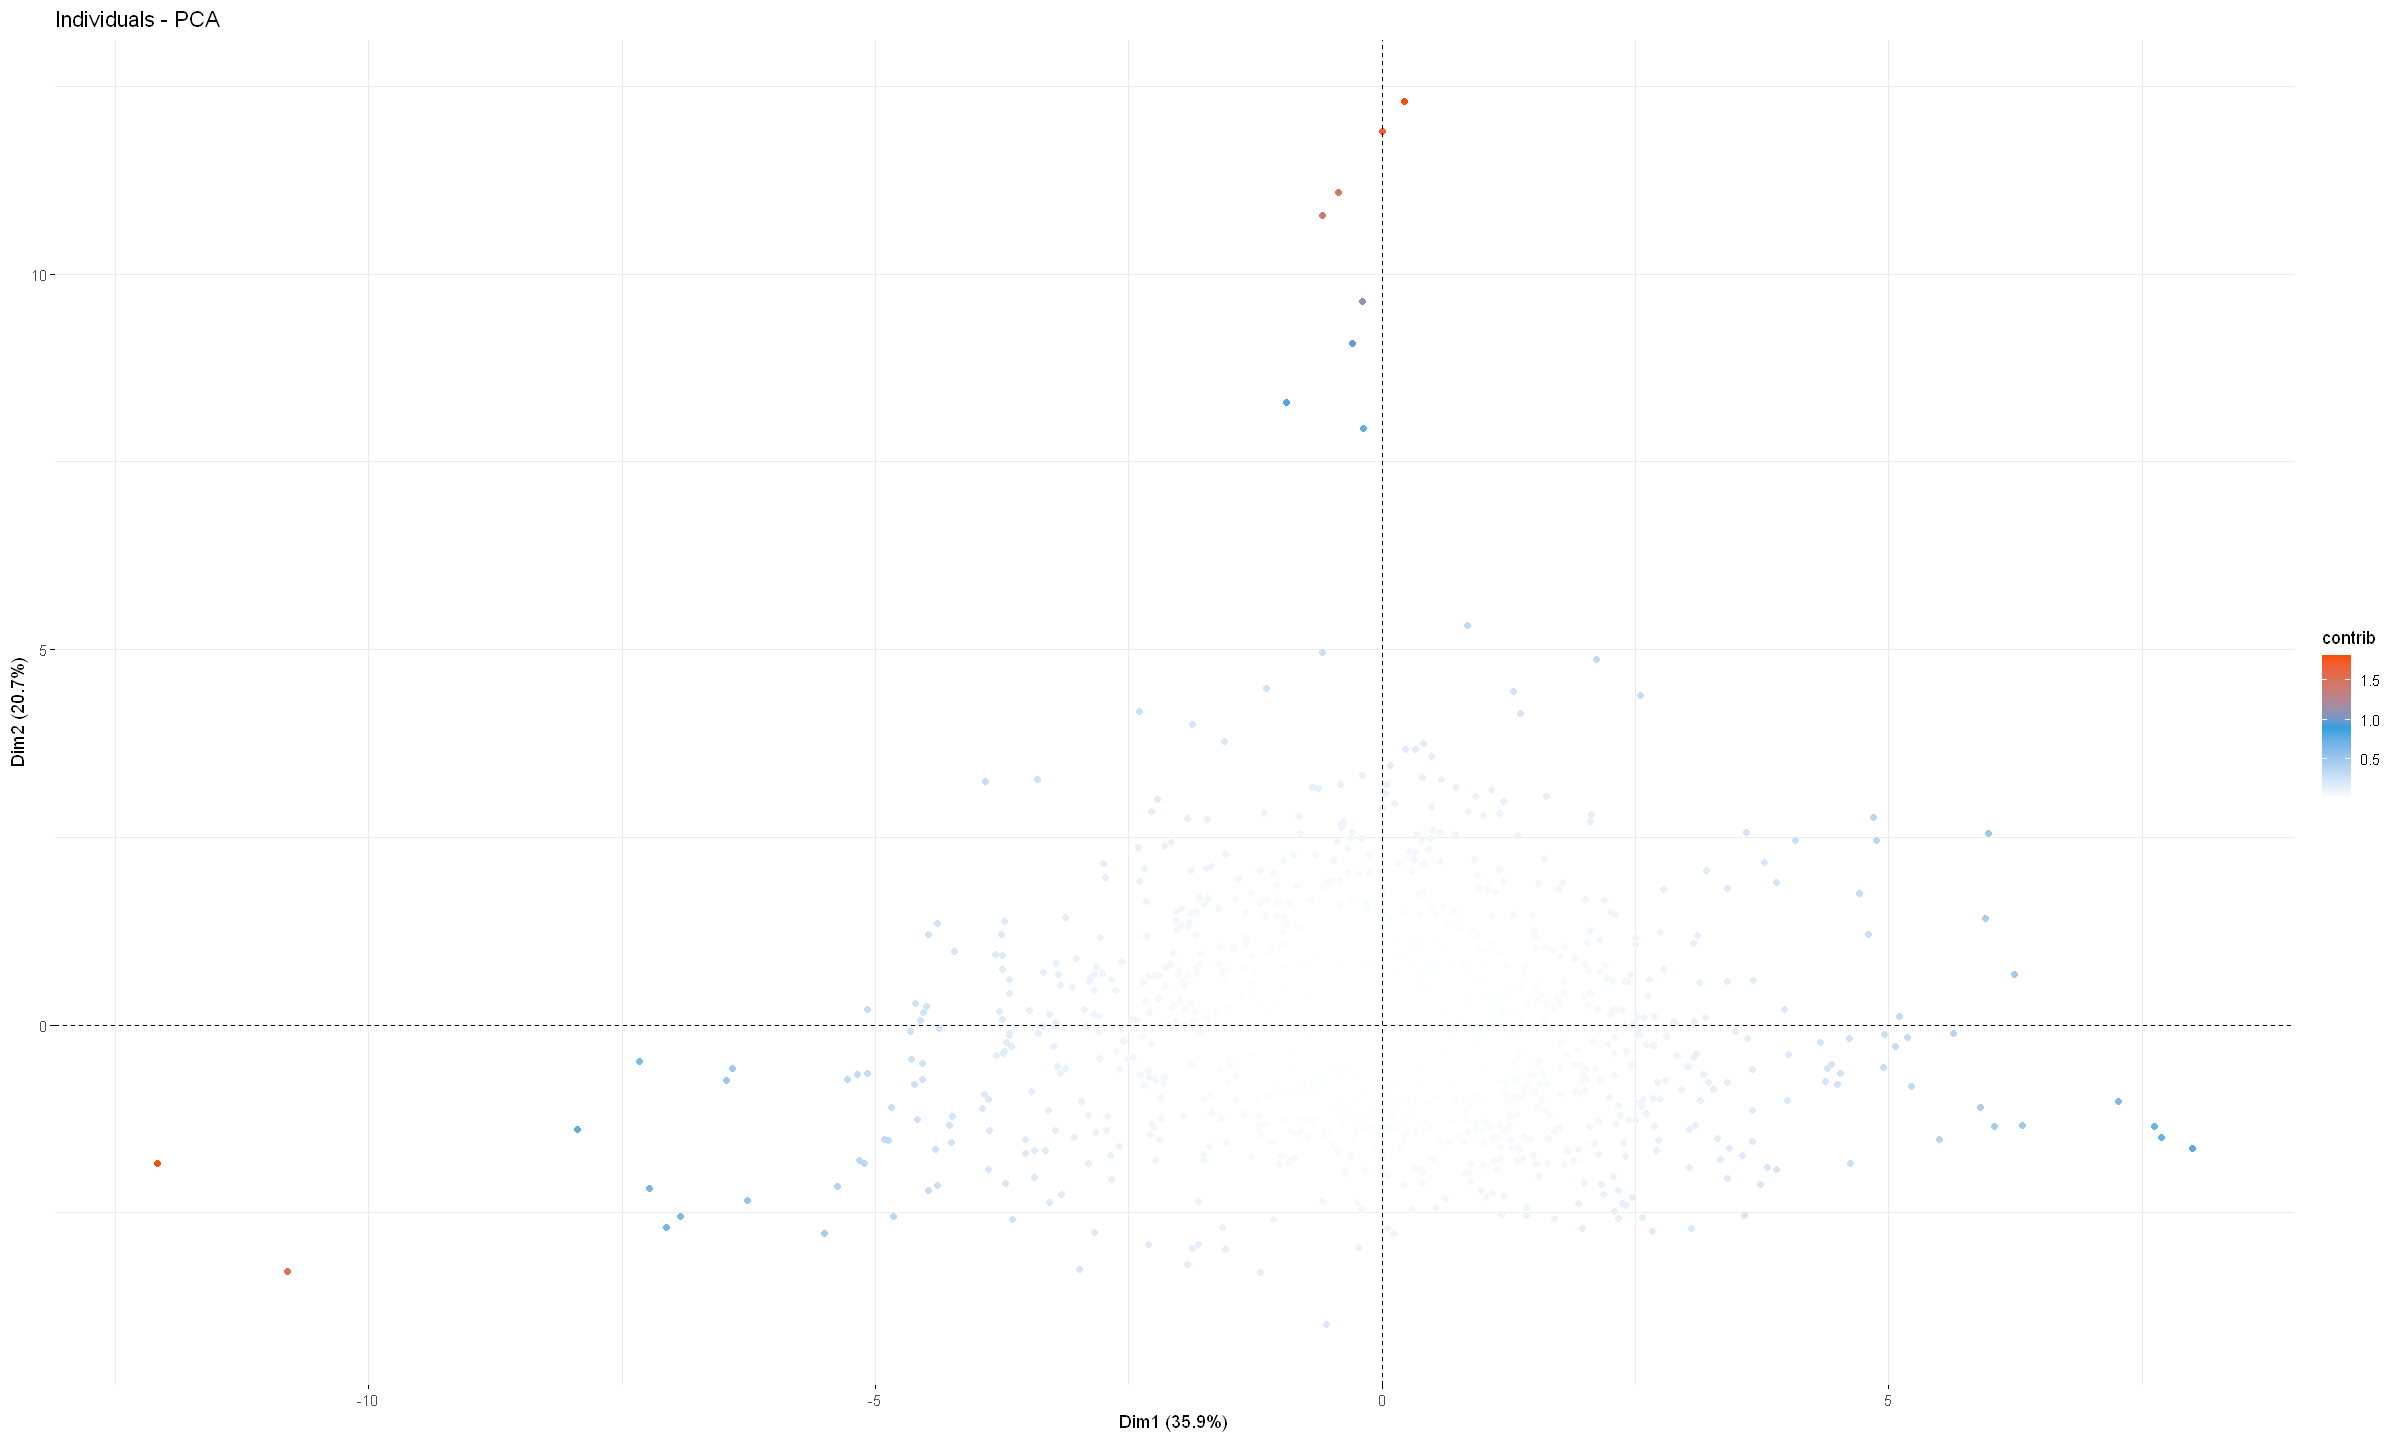

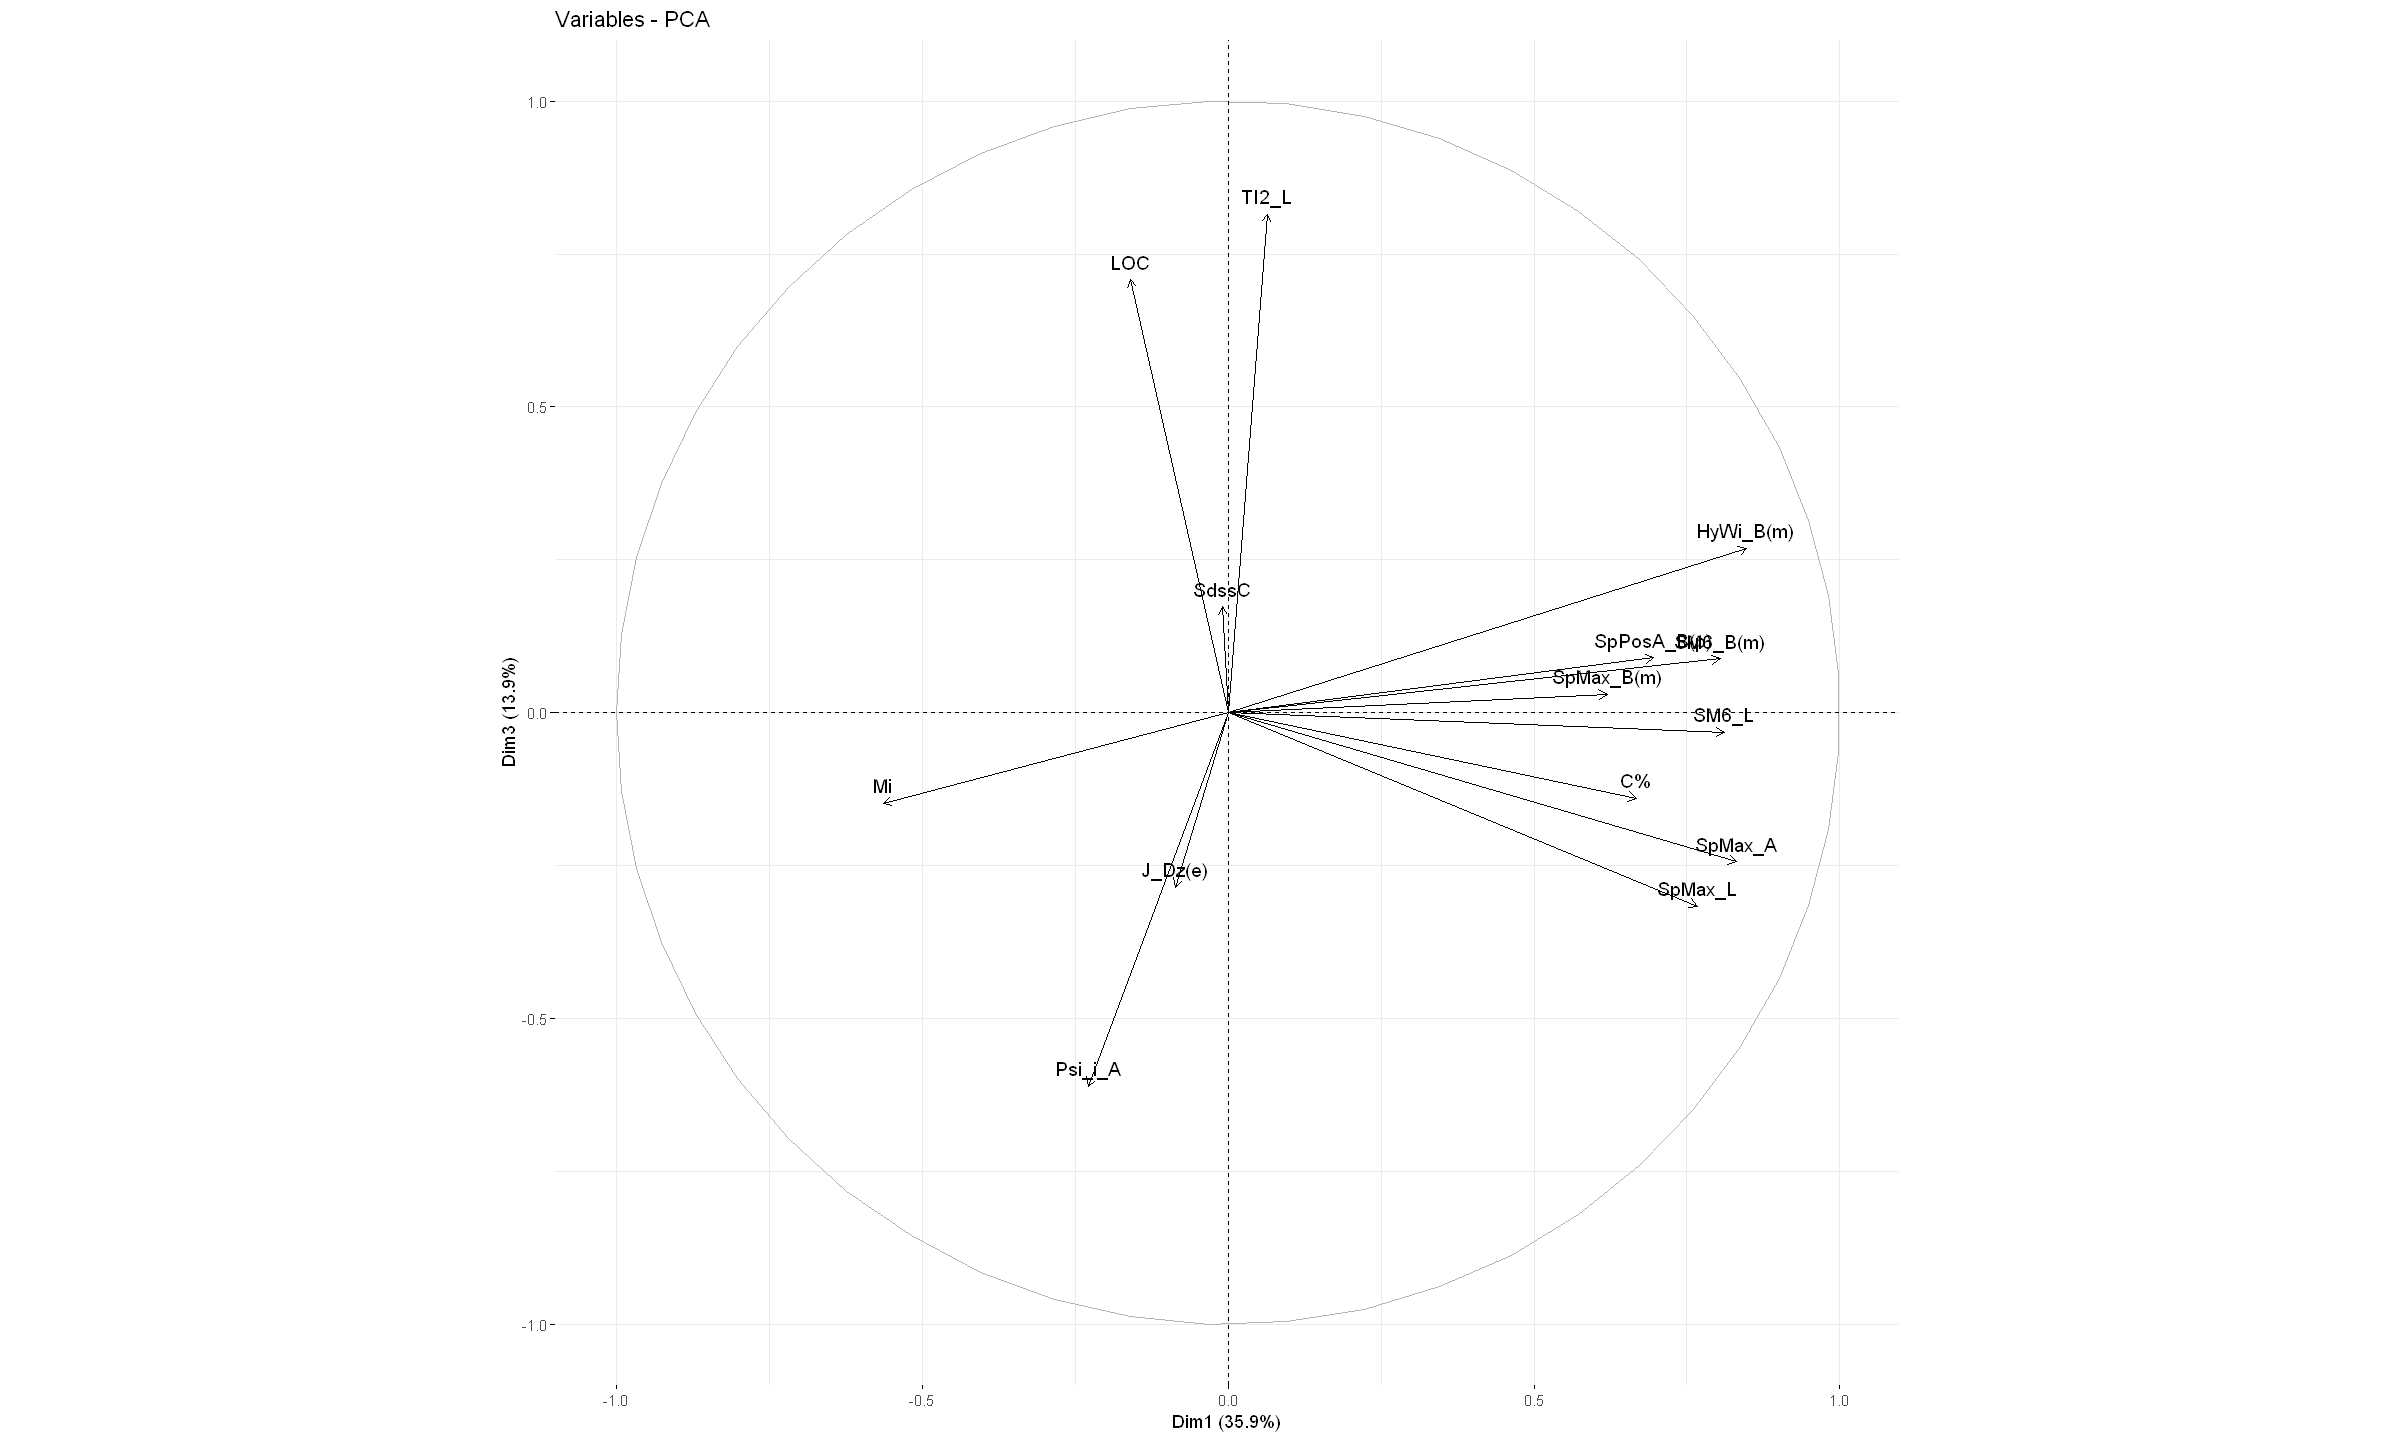

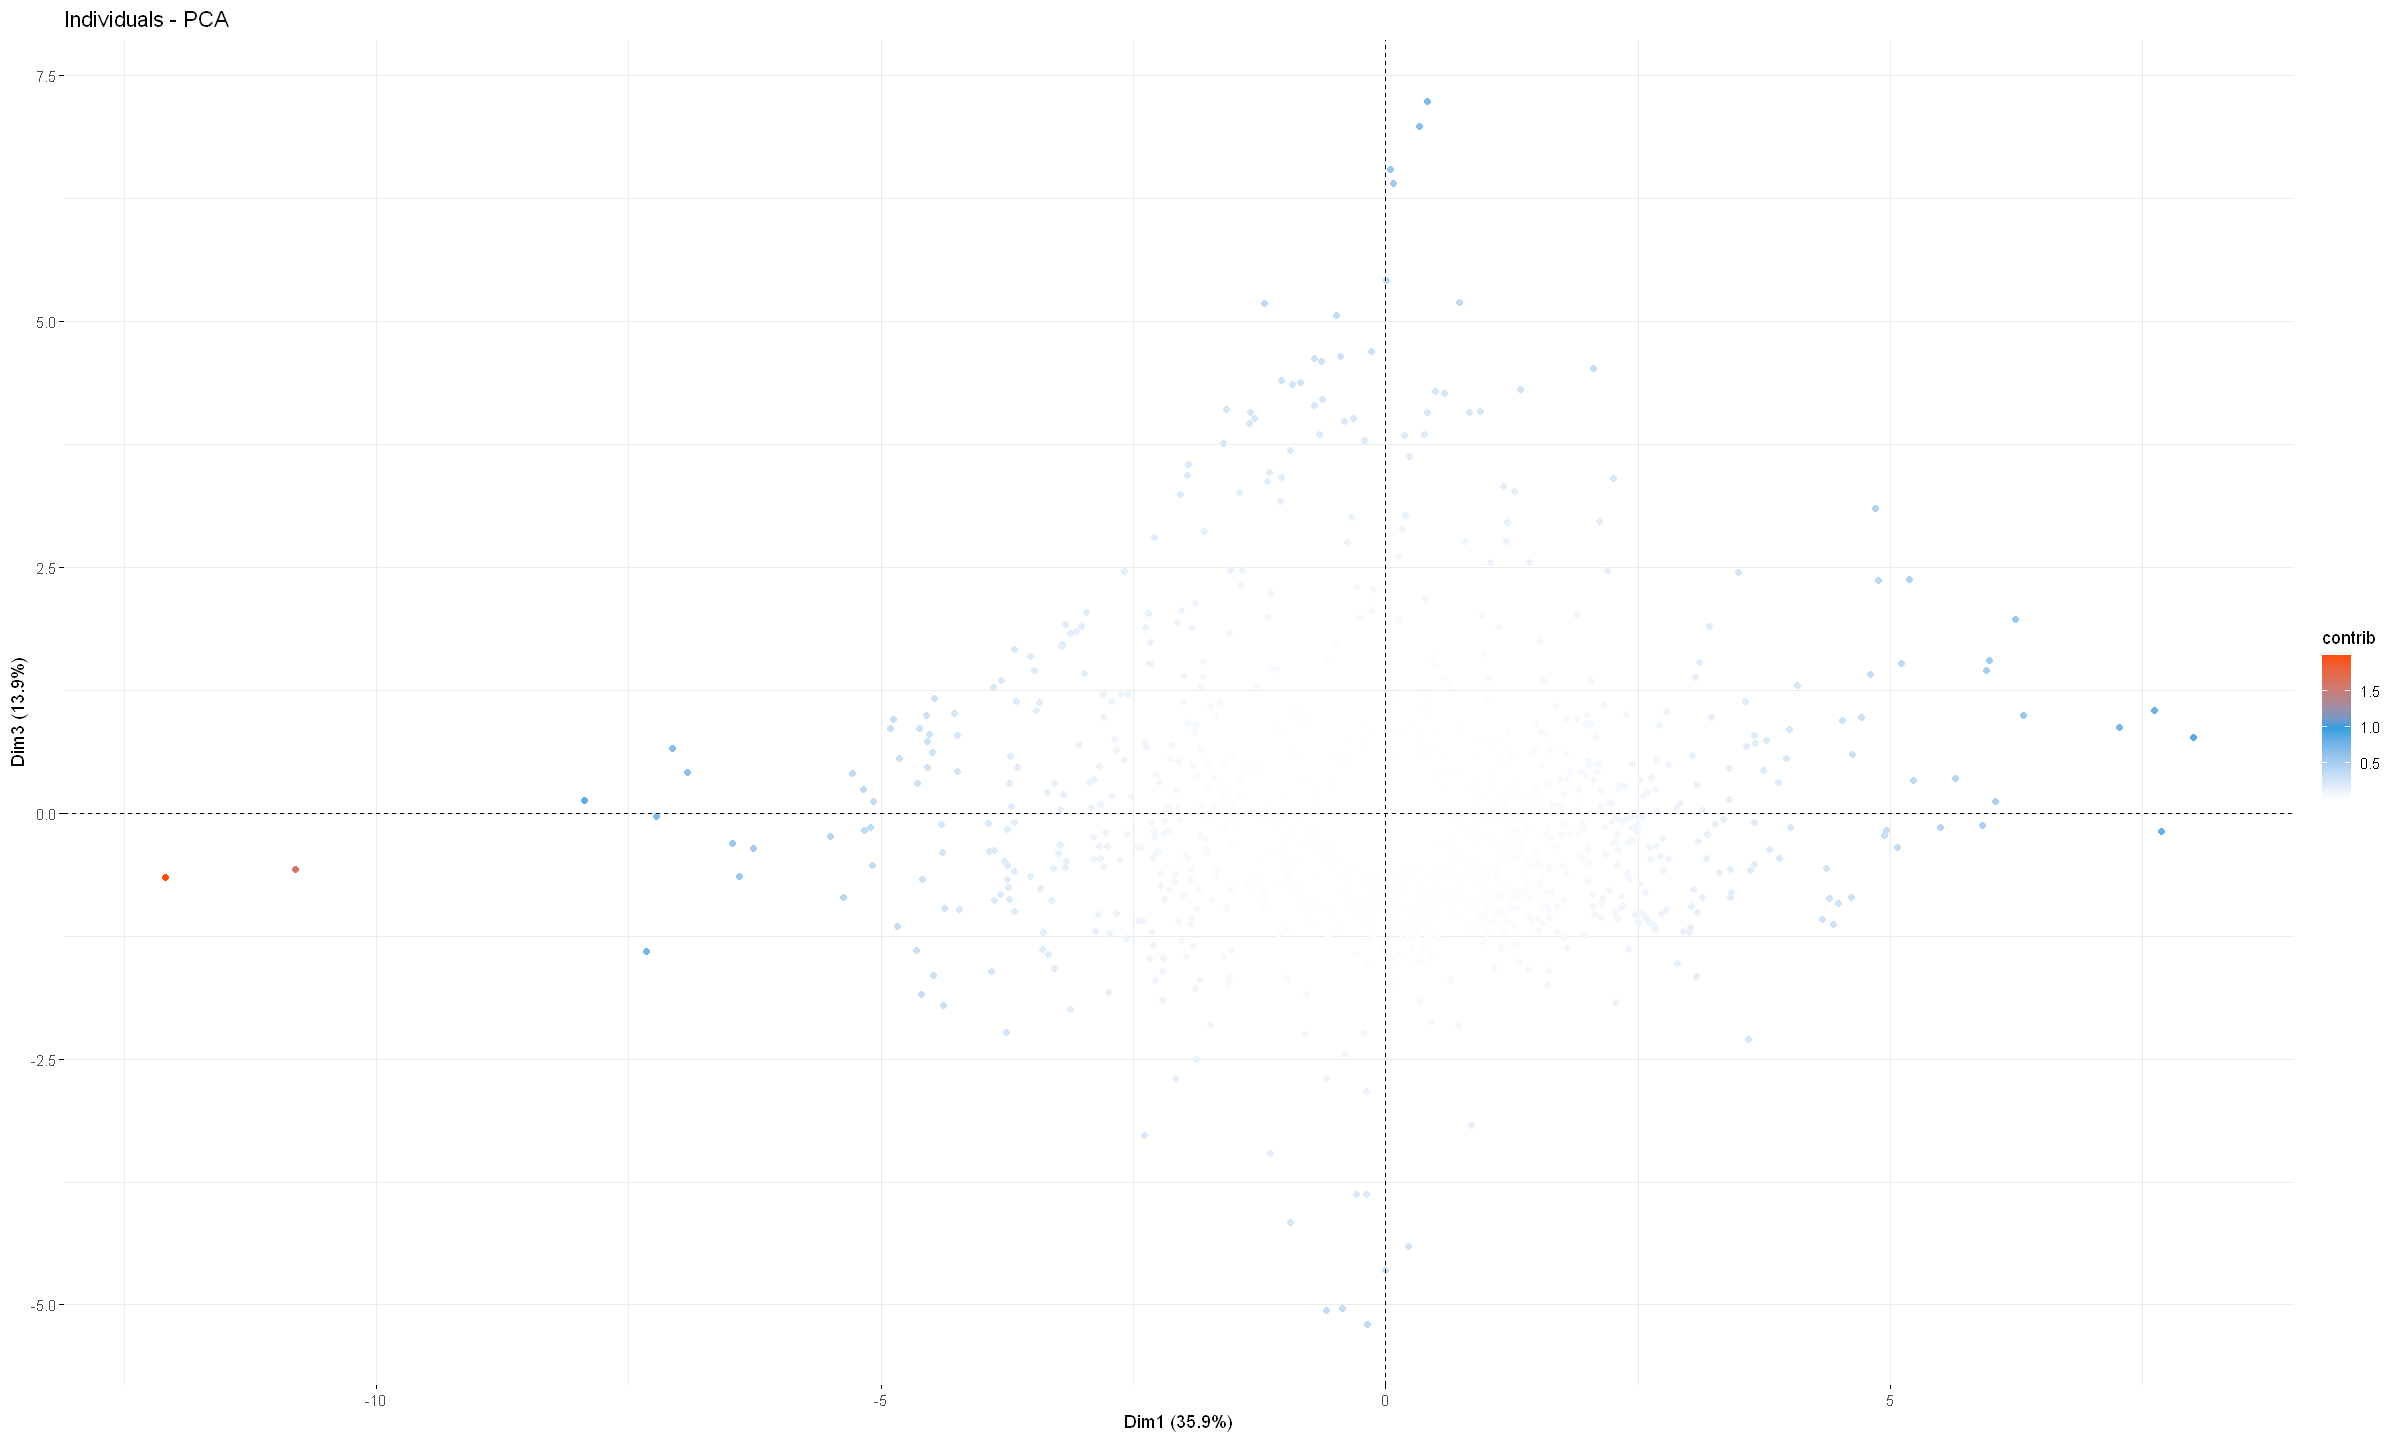

In [21]:
fviz_pca_var(acp)
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ))
fviz_pca_var(acp,axes=c(1,3))
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))

**Comment**:

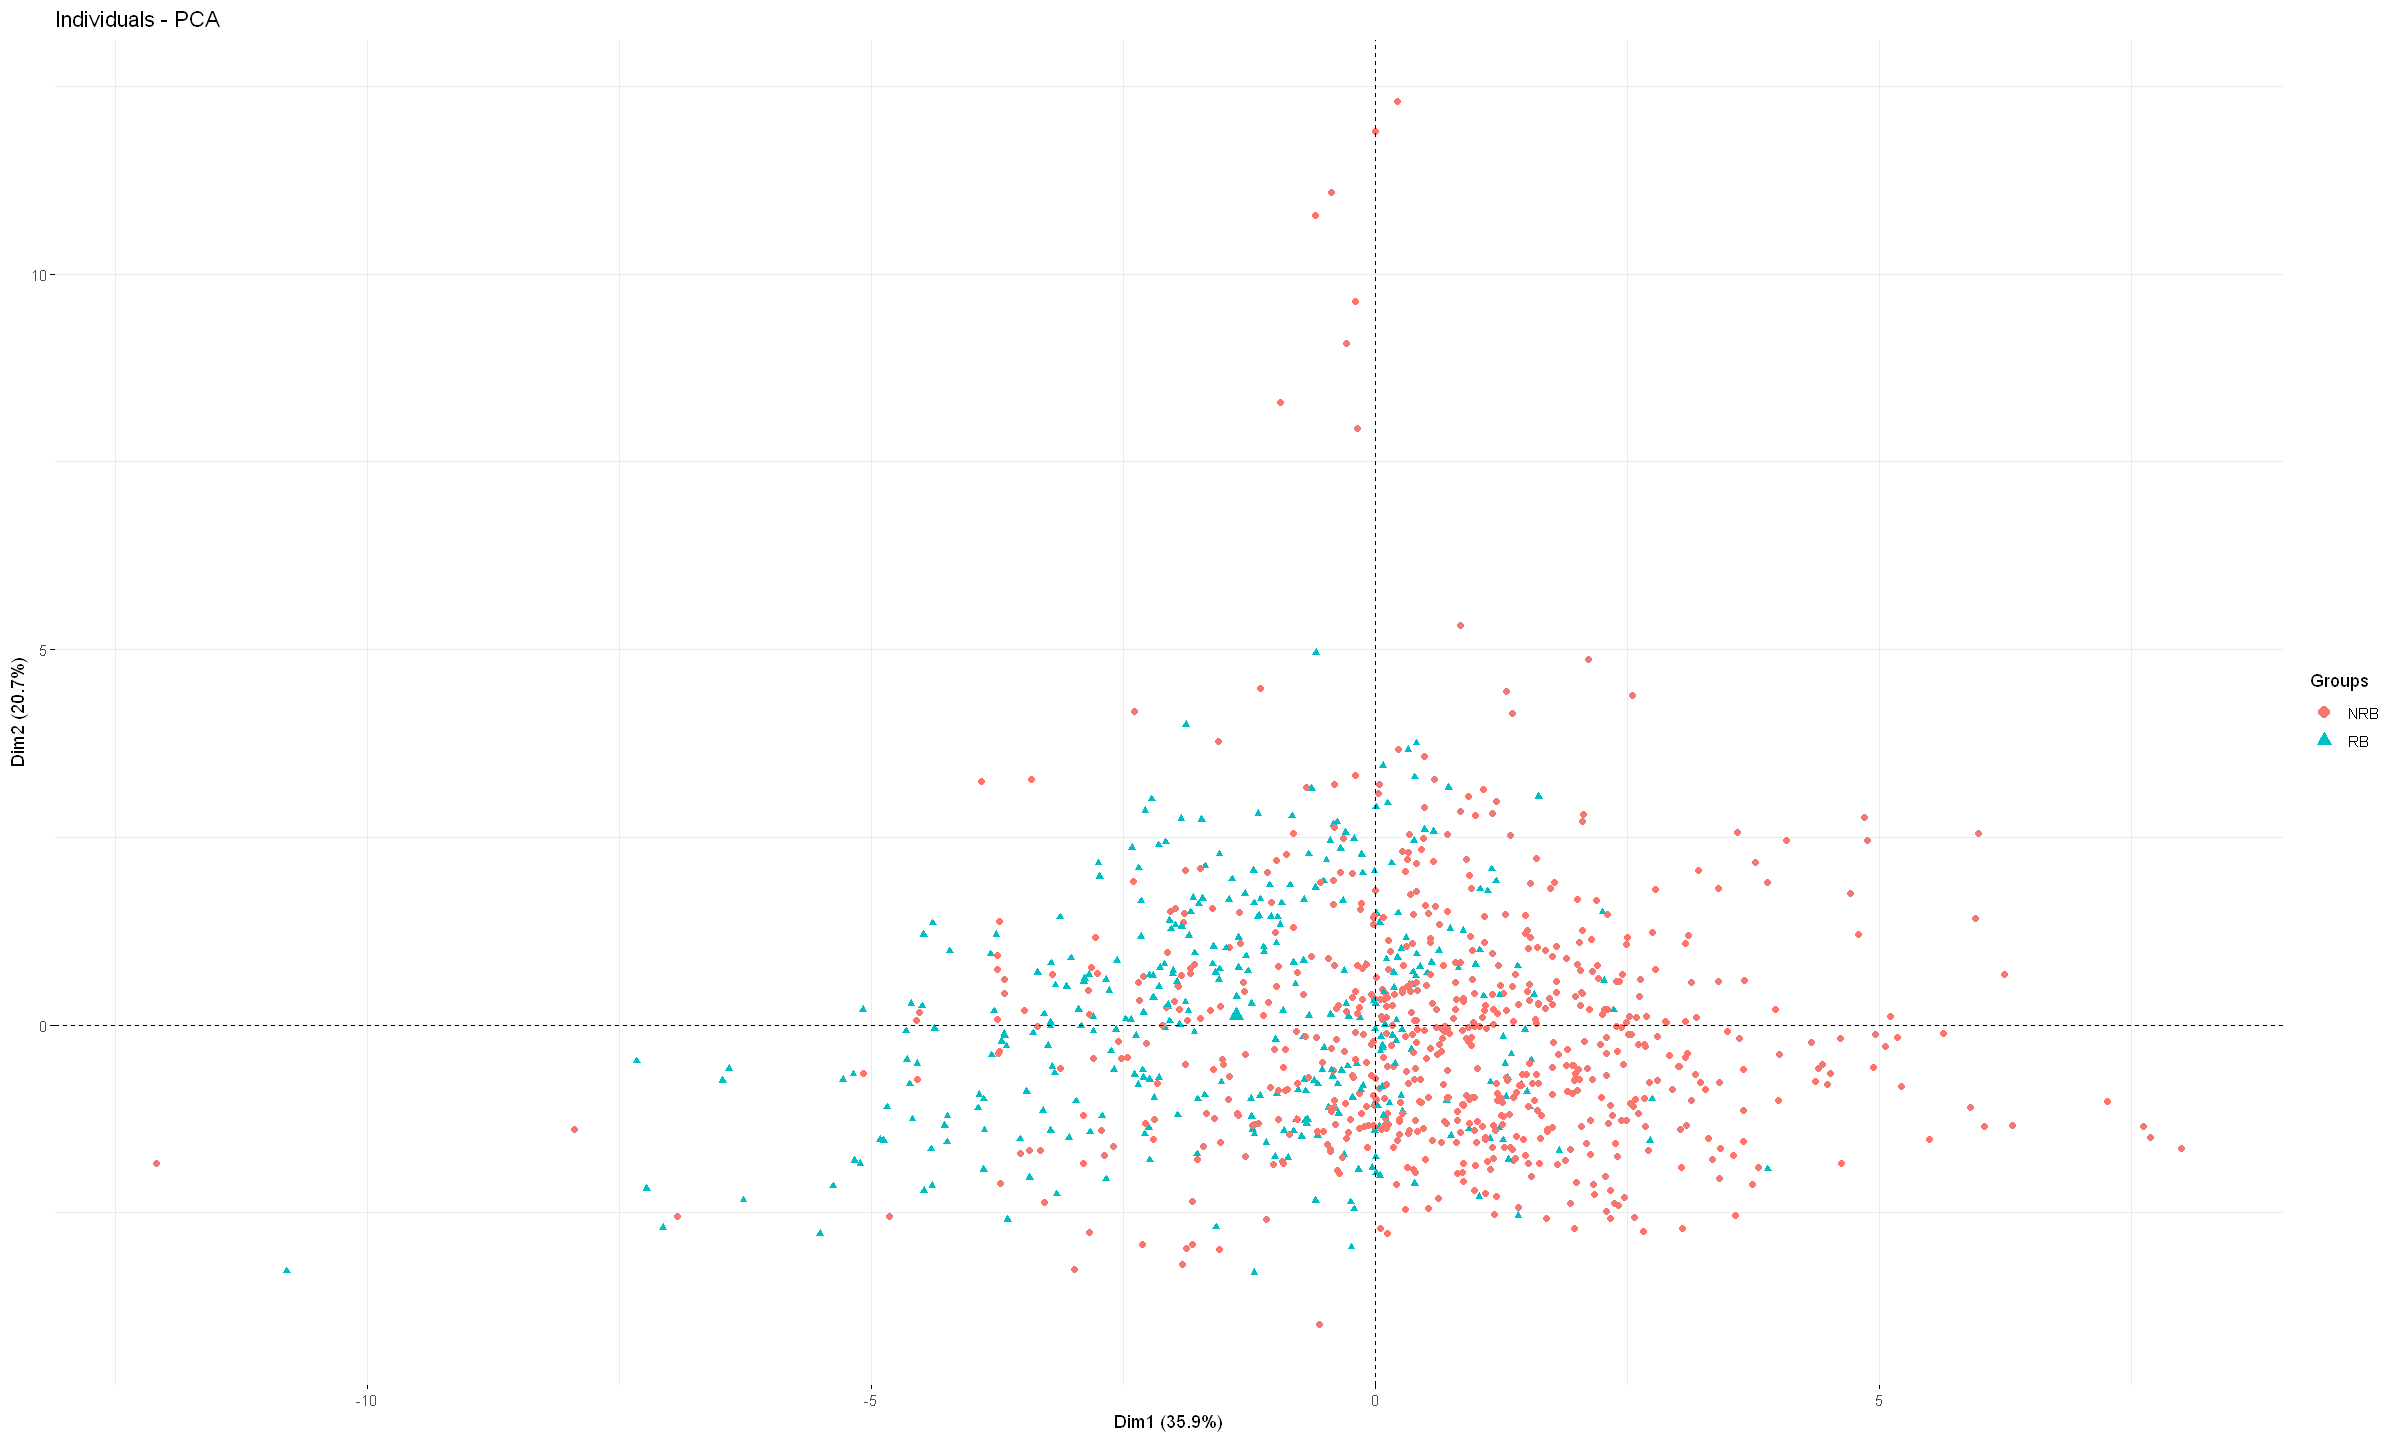

In [22]:
fviz_pca_ind(acp, label="none", habillage=biodeg$Response)

# Training & test set splitting 

## Get dummy variables

In [23]:
set.seed(42) # initialisation du générateur
# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(data) # nombre de lignes dans les données
nvar <- ncol(data) # nombre de colonnes
# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio) 
# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi) 

In [60]:
data$Response = biodeg$Response
names(data) <- make.names(names(data))

data_transform$Response <- biodeg$Response
names(data_transform) <- make.names(names(data_transform))

head(data)

,SpMax_L,J_Dz.e.,C.,SdssC,HyWi_B.m.,LOC,SM6_L,F03.C.O.,Me,Mi,...,B01.C.Br.,B03.C.Cl.,SpMax_A,Psi_i_1d,SdO,TI2_L,SpMax_B.m.,Psi_i_A,SM6_B.m.,Response
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<dbl>,<dbl>,...,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,3.919,2.6909,31.4,0.000,3.106,2.550,9.002,0,0.960,1.142,...,0,0,1.932,0.011,0.000,4.489,2.949,1.591,7.253,RB
2,4.170,2.1144,30.8,0.000,2.461,1.393,8.723,1,0.989,1.144,...,0,0,2.214,-0.204,0.000,1.542,3.315,1.967,7.257,RB
3,3.932,3.2512,26.7,0.000,3.279,2.585,9.110,0,1.009,1.152,...,0,0,1.942,-0.008,0.000,4.891,3.076,2.417,7.601,RB
4,3.000,2.7098,20.0,0.000,2.100,0.918,6.594,0,1.108,1.167,...,0,0,1.414,1.073,8.361,1.333,3.046,5.000,6.690,RB
5,4.236,3.3944,29.4,-0.271,3.449,2.753,9.528,1,1.004,1.147,...,0,0,1.985,-0.002,10.348,5.588,3.351,2.405,8.003,RB
6,4.236,3.4286,28.6,-0.275,3.313,2.522,9.383,1,1.014,1.149,...,0,0,1.980,-0.008,10.276,4.746,3.351,2.556,7.904,RB


In [61]:
# construction de l'échantillon d'apprentissage
datapp <- data[appri, ] 
# construction de l'échantillon test
datest <- data[testi, ] 

datapp_transform <- data_transform[appri,]
datest_transform <- data_transform[testi,]

# 4. Model comparison

## 4.2. Support Vector Machine 

### 4.2.1. SVM with raw data

In [42]:
library(e1071)
? tune.svm

In [48]:
# With linear kernel
svm.raw.tune.linear = tune.svm(Response ~ ., 
                               data = datapp, 
                               kernel = 'linear',
                               type = 'C-classification',
                               cost = c(0.5, 1, 3, 5, 10, 50, 100, 200) )

svm.raw.linear = svm(Response~.,data=datapp,cost = svm.raw.tune.linear$best.parameters$cost)
pred.raw.linear = predict(svm.raw.linear,newdata=datest)
table(pred.raw.linear, datest$Response)

               
pred.raw.linear NRB  RB
            NRB 131  18
            RB   13  49

In [53]:
# With sigmoid kernel
svm.raw.tune.sigmoid = tune.svm(Response ~ ., 
                               data = datapp, 
                               kernel = 'sigmoid',
                               type = 'C-classification',
                               cost = c(0.5, 1, 3, 5, 10, 50, 100, 200),
                               gamma = c(0.01,0.05, 0.1, 0.5, 1, 2, 5) )

svm.raw.sigmoid = svm(Response~.,data=datapp,cost = svm.raw.tune.sigmoid$best.parameters$cost, 
                      gamma = svm.raw.tune.sigmoid$best.parameters$gamma)
pred.raw.sigmoid = predict(svm.raw.sigmoid,newdata=datest)
table(pred.raw.sigmoid, datest$Response)

                
pred.raw.sigmoid NRB  RB
             NRB 131  17
             RB   13  50

In [55]:
# With rbf kernel
svm.raw.tune.rbf = tune.svm(Response ~ ., 
                            data = datapp, 
                            kernel = 'radial',
                            type = 'C-classification',
                            cost = c(0.5, 1, 3, 5, 10, 50, 100, 200),
                            gamma = c(0.01,0.05, 0.1, 0.5, 1, 2, 5) )

svm.raw.rbf = svm(Response~.,data=datapp,cost = svm.raw.tune.rbf$best.parameters$cost, 
                    gamma = svm.raw.tune.rbf$best.parameters$gamma)
pred.raw.rbf = predict(svm.raw.rbf,newdata=datest)
table(pred.raw.rbf, datest$Response)

            
pred.raw.rbf NRB  RB
         NRB 129  20
         RB   15  47

### 4.2.2. SVM with transformed data

In [67]:
# With linear kernel
svm.trans.tune.linear = tune.svm(Response ~ ., 
                               data = datapp_transform, 
                               kernel = 'linear',
                               type = 'C-classification',
                               cost = c(0.5, 1, 3, 5, 10, 50, 100, 200) )

svm.trans.linear = svm(Response~.,data=datapp_transform,cost = svm.trans.tune.linear$best.parameters$cost)
pred.trans.linear = predict(svm.trans.linear,newdata=datest_transform)
table(pred.trans.linear, datest_transform$Response)

                 
pred.trans.linear NRB  RB
              NRB 127  17
              RB   17  50

In [68]:
# With sigmoid kernel
svm.trans.tune.sigmoid = tune.svm(Response ~ ., 
                               data = datapp_transform, 
                               kernel = 'sigmoid',
                               type = 'C-classification',
                               cost = c(0.5, 1, 3, 5, 10, 50, 100, 200),
                               gamma = c(0.01,0.05, 0.1, 0.5, 1, 2, 5) )

svm.trans.sigmoid = svm(Response~.,data=datapp_transform,cost = svm.trans.tune.sigmoid$best.parameters$cost, 
                        gamma = svm.trans.tune.sigmoid$best.parameters$gamma)
pred.trans.sigmoid = predict(svm.trans.sigmoid,newdata=datest_transform)
table(pred.trans.sigmoid, datest_transform$Response)

                  
pred.trans.sigmoid NRB  RB
               NRB 131  19
               RB   13  48

In [69]:
# With rbf kernel
svm.trans.tune.rbf = tune.svm(Response ~ ., 
                            data = datapp_transform, 
                            kernel = 'radial',
                            type = 'C-classification',
                            cost = c(0.5, 1, 3, 5, 10, 50, 100, 200),
                            gamma = c(0.01,0.05, 0.1, 0.5, 1, 2, 5) )

svm.trans.rbf = svm(Response~.,data=datapp_transform,cost = svm.trans.tune.rbf$best.parameters$cost, 
                    gamma = svm.trans.tune.rbf$best.parameters$gamma)
pred.trans.rbf = predict(svm.trans.rbf,newdata=datest_transform)
table(pred.trans.rbf, datest_transform$Response)

              
pred.trans.rbf NRB  RB
           NRB 130  18
           RB   14  49

## 4.3. Optimal tree 

In [ ]:
library(rpart) 
library(rpart.plot)

tree.class = rpart(Response~., data = datapp, method = 'class')

rpart.plot(tree.class)

In [279]:
predict_test = predict(tree.class, datest, type = "class")
confusion_matrix = table(datest$Response, predict_test)
confusion_matrix

     predict_test
      NRB  RB
  NRB 128  16
  RB   18  49

## 4.4. Random forest 

In [284]:
library(randomForest)
forest.class <- randomForest(Response ~ ., 
                        data = datapp, 
                        importance = TRUE,
                             proximity = TRUE
                        )
print(forest.class)


Call:
 randomForest(formula = Response ~ ., data = datapp, importance = TRUE,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 14.81%
Confusion matrix:
    NRB  RB class.error
NRB 501  54   0.0972973
RB   71 218   0.2456747


In [47]:
library(caret)

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




In [ ]:
p2 <- predict(forest.class, datest)
confusionMatrix(p2, datest$Response)


In [ ]:
plot(forest.class)

In [ ]:
varImpPlot(forest.class)

### Grid Search exhautive

## Boosting algorithm

### AdaBoost

In [91]:
# install.packages('adabag')
# install.packages('EZtune')

In [76]:
library('EZtune')

In this section, we use the package EZtune that allows to automatically find the best model with optimal parameters. 

In [100]:
# On raw data
ada.raw <- eztune(x=datapp[,1:20], y = datapp$Response,method='ada')

pred.ada.raw <- predict(ada.raw, newdata = datest)
table(pred.ada.raw[,1], datest$Response)

     
      NRB  RB
  NRB 132  16
  RB   12  51

### Gradient Boosting Models

In [102]:
# On raw data
gbm.raw <- eztune(x=datapp[,1:20], y = datapp$Response,method='gbm')

pred.gbm.raw <- predict(gbm.raw, newdata = datest)
table(pred.gbm.raw[,1], datest$Response)

     
      NRB  RB
  NRB 131  16
  RB   13  51

# Algorithm comparison

## ROC curve

In [ ]:
# Choisir la liste des méthodes et l’effort d’optimisation
models=c("gbm","rf","nnet","glmStepAIC","xgbTree")
noptim=c(6,6,6,6,6)
# Initialiser le générateur et fixer le nombre d’itérations
# Changer ces valeurs. Attention au temps de calcul! Être patient!
Niter=10 ; Init=11  
# Appel de la fonction définie en annexe
pred.ozone=pred.autom(X,Y,methodes=models,N=Niter,xinit=Init,size=noptim,type="prob")

## Monte Carlo cross validation